In [ ]:
"""
Purpose: To run the soma splitting 
on the processed neurons

"""


In [1]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/meshAfterParty/")

from importlib import reload

In [11]:
import datajoint_utils as du

In [12]:
test_mode = True

In [13]:
import minfig
import time
import numpy as np
#want to add in a wait for the connection part
random_sleep_sec = np.random.randint(0, 200)
print(f"Sleeping {random_sleep_sec} sec before conneting")
if not test_mode:
    time.sleep(random_sleep_sec)
print("Done sleeping")

du.config_celii()
du.set_minnie65_config_segmentation(minfig)
du.print_minnie65_config_paths(minfig)

#configuring will include the adapters
minnie,schema = du.configure_minnie_vm()

INFO - 2021-01-12 18:05:21,466 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-01-12 18:05:21,468 - settings - Setting database.user to celiib
INFO - 2021-01-12 18:05:21,469 - settings - Setting database.password to newceliipass
INFO - 2021-01-12 18:05:21,475 - settings - Setting enable_python_native_blobs to True


Sleeping 93 sec before conneting
Done sleeping
Current path for external_segmentation_path = /mnt/dj-stor01/platinum/minnie65/02
Current path for external_mesh_path = /mnt/dj-stor01/platinum/minnie65/02/meshes
Current path for external_decimated_mesh_path = /mnt/dj-stor01/platinum/minnie65/02/decimated_meshes
Current path for external_skeleton_path = /mnt/dj-stor01/platinum/minnie65/02/skeletons


INFO - 2021-01-12 18:05:21,799 - settings - Setting enable_python_native_blobs to True


# Defining the Table

In [14]:
import neuron_utils as nru
import neuron
import trimesh_utils as tu
import numpy as np

In [15]:
import meshlab
meshlab.set_meshlab_port(current_port=None)

No port chosen so picked random port 436


In [16]:
#so that it will have the adapter defined
from datajoint_utils import *

In [17]:
key_source = minnie.Decomposition()
key_source

segment_id segment id unique within each Segmentation,decimation_version,decimation_ratio ratio of remaining mesh vertices/faces (which ones depends on what metric the decimation technique uses),ver the version number of the materializaiton,process_version the version of the preprocessing pipeline run,decomposition,n_vertices number of vertices,n_faces number of faces,n_not_processed_soma_containing_meshes the number of meshes with somas that were not processed,n_error_limbs the number of limbs that are touching multiple somas or 1 soma in multiple places,n_same_soma_multi_touching_limbs number of limbs that touch the same soma multiple times,n_multi_soma_touching_limbs number of limbs that touch multiple somas,n_somas number of soma meshes detected,n_limbs,n_branches,max_limb_n_branches,skeletal_length,max_limb_skeletal_length,median_branch_length gives information on average skeletal length to next branch point,width_median median width from mesh center without spines removed,width_no_spine_median median width from mesh center with spines removed,width_90_perc 90th percentile for width without spines removed,width_no_spine_90_perc 90th percentile for width with spines removed,n_spines,spine_density n_spines/ skeletal_length,spines_per_branch,skeletal_length_eligible the skeletal length for all branches searched for spines,n_spine_eligible_branches the number of branches that were checked for spines because passed width threshold,spine_density_eligible n_spines/skeletal_length_eligible,spines_per_branch_eligible n_spines/n_spine_eligible_branches,total_spine_volume the sum of all spine volume,spine_volume_median median of the spine volume for those spines with able to calculate volume,spine_volume_density total_spine_volume/skeletal_length,spine_volume_density_eligible total_spine_volume/skeletal_length_eligible,spine_volume_per_branch_eligible total_spine_volume/n_spine_eligible_branches,run_time the amount of time to run (seconds)
864691134947393276,0,0.25,29.00,0,=BLOB=,1400375,2824255,0,0,0,0,1,8,185,95,7824282.380889241,3678098.820011452,27089.939,79.7,79.7,495.553,456.914,2130,0.00027222943860033875,11.513513513513514,3959944.957,71,0.0005378862643620327,30.0,217619006067.48697,59992605.27867258,27813.2863147961,54955.05832291976,3065056423.485732,1298.7173
864691135012398582,0,0.25,29.00,0,=BLOB=,1376990,2794781,0,4,1,4,2,9,331,129,13903026.646273784,4736919.313152046,24796.33,187.388,186.295,502.297,460.402,5205,0.0003743789127668123,15.725075528700906,8722973.997,175,0.0005967001623288228,29.743,911267911282.6133,94869445.23332134,65544.57057930235,104467.5716786518,5207245207.329219,2604.4532
864691135012471798,0,0.25,29.00,0,=BLOB=,879119,1793791,0,1,1,0,1,4,289,245,10545701.713406056,8374871.339385826,20318.51,101.514,101.514,478.023,425.897,2658,0.0002520458166023281,9.197231833910035,6162133.268,126,0.00043134412782063836,21.095,334671873701.14355,73603234.65274492,31735.382129735117,54311.041184243266,2656125981.7551074,3508.8503
864691135012571126,0,0.25,29.00,0,=BLOB=,1405952,2834699,0,5,5,0,1,9,439,190,15000091.889040658,5950211.886670216,22542.824,139.648,139.648,468.777,408.375,5404,0.0003602644597096276,12.309794988610479,8640395.253,216,0.0006254343512958735,25.019,976000132123.9475,107471073.68609047,65066.27688307904,112957.81078823611,4518519130.203461,4797.4468
864691135012905110,0,0.25,29.00,0,=BLOB=,816541,1676641,0,1,1,0,1,11,251,106,9675627.15202663,3911641.696373985,24465.544,87.846,87.846,383.783,363.92,2135,0.00022065753118161535,8.50597609561753,5031174.543,95,0.00042435419040877436,22.474,388395999218.4453,100623801.14855957,40141.68726386827,77197.87812943809,4088378939.1415296,2073.6969
864691135065018692,0,0.25,29.00,0,=BLOB=,927599,1896021,0,1,1,1,2,19,273,62,10133780.765040418,2065336.4266345776,17535.369,109.943,109.943,546.409,539.932,2029,0.0002002214224921519,7.4322344322344325,5474214.867,121,0.00037064675926978005,16.769,269603278823.37152,70905449.51999664,26604.41202294909,49249

In [20]:
minnie.NeuronSplitSuggestions()

segment_id segment id unique within each Segmentation,decimation_version,decimation_ratio ratio of remaining mesh vertices/faces (which ones depends on what metric the decimation technique uses),ver the version number of the materializaiton,process_version the version of the preprocessing pipeline run,split_results will store the results of how to split the limbs of neuron objects,run_time the amount of time to run (seconds)


In [10]:
import numpy as np
import time
import proofreading_utils as pru

@schema
class NeuronSplitSuggestions(dj.Computed):
    definition="""
    -> minnie.Decomposition
    ---
    split_results: longblob #will store the results of how to split the limbs of neuron objects
    run_time=NULL : double                   # the amount of time to run (seconds)

    """

    key_source = minnie.Decomposition()
    
    def make(self,key):
        """
        Pseudocode for process:

        1) Fetch the neuron object
        2) Run the mutli-split suggestions
        3) Calculate the total time
        4) Write the results to the table
        """
        whole_pass_time = time.time()
        #1) Get the segment id from the key
        segment_id = key["segment_id"]
        print(f"\n\n----- Working on Neuron {segment_id}-------")
        
        neuron_obj = (minnie.Decomposition & key).fetch1("decomposition")
        
        limb_results = pru.multi_soma_split_suggestions(neuron_obj,plot_intermediates=False)
        
        #7) Pass stats and file location to insert
        new_key = dict(key,
                       split_results = limb_results,
                       run_time=np.round(time.time() - whole_pass_time,4)
                      )

        self.insert1(new_key, allow_direct_insert=True, skip_duplicates=True)

        print(f"\n\n ------ Total time for Splitting {segment_id} = {time.time() - whole_pass_time} ------")
    

# Running the Populate

In [22]:
curr_table = (minnie.schema.jobs & "table_name='__neuron_split_suggestions'")
(curr_table).delete()# & "status='error'")
#curr_table.delete()
#(curr_table & "error_message = 'ValueError: need at least one array to concatenate'").delete()

INFO - 2021-01-12 18:06:20,663 - autopopulate - Found 80 keys to populate
INFO - 2021-01-12 18:06:20,684 - connection - Transaction started
INFO - 2021-01-12 18:06:20,686 - autopopulate - Populating: {'segment_id': 864691135081745143, 'decimation_version': 0, 'decimation_ratio': Decimal('0.25'), 'ver': Decimal('29.00'), 'process_version': 0}


Populate Started


----- Working on 864691135081745143-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = [1]
multi_touch_limbs = []


 -------- Working on limb 1------------
Starting combinations to process = [[ 1 29]]


---- working on disconnecting 1 and 29
---- This disconnects S0_0 from S1_0  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 1
Total number of graphs at the end of the split AFTER DIRECTIONAL = 1
Shortest path = [1, 0, 3, 28, 29]

 --------- START OF GET BEST EDGE --------- 
curr_limb.deleted_edges=[]
consider_path_neighbors_for_removal is set so segments_to_consider = [ 0  2  3  4 26 28 30]
Short segments to combine = []
Found 0 high degree coordinates to cut
Skipping endnode 1 because skeletal distance was 81.01176780093736 and threshold was 2500
skip_nodes = [1]

Attempting the doubling back check (symmetrical so don't need to check from both sides)


  Edge: [0 3]: curr_angle = 7.56
  Edge: [ 3 28]: curr_angle = 46.8
  Edge: [28 29]: curr_angle = 21.95

Total time for doubling_back = 0.39366722106933594

Attempting the width jump check (attempting from both sides)
  Edge: [0 3]: jump = -146.96
  Edge: [ 3 28]: jump = 296.23
Adding error edge [ 3 28] because width jump was 296.22662615893137
  Edge: [28 29]: jump = 108.09
Total time for width = 0.35536766052246094
Path starting at 1 had err_edges: [[3, 28]]
  Edge: [29 28]: jump = -108.09
  Edge: [28  3]: jump = -296.23
  Edge: [3 0]: jump = 283.66
Adding error edge [3 0] because width jump was 283.6553640132787
Total time for width = 0.3524963855743408
Path starting at 29 had err_edges: [[3, 0]]
first_error_sizes = [296.22662615893137, 283.6553640132787], winning_path = 0
***inside resolve crossover!!!!****
coordinate_branches = [3, 26, 28]
3 = red
26 = aqua
28 = purple
Angle between 3 and 26 = 108.02 
Angle between 3 and 28 = 58.66 
Angle between 26 and 28 = 14.52 
Final Matches =

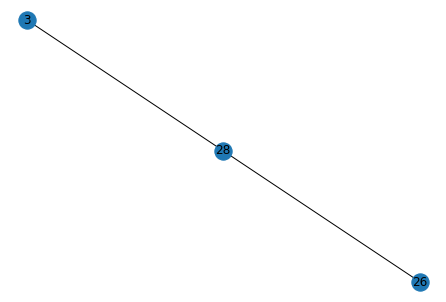

match_branches = [[26, 28]]
edges_to_delete (resolve crossover) = [[3, 26], [3, 28]]
edges_to_create (resolve crossover) = [[26, 28]]
edges_to_delete (cut_limb_network) = [array([ 3, 26]), array([ 3, 28])]
edges_to_create = [[26, 28]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 4, 5, 7, 8, 9}
Comp 1 = {6, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
curr_limb_copy.deleted_edges = [array([ 3, 26]), array([ 3, 28])]
curr_limb_copy.created_edges = [[26, 28]]
After get best cut: cut_edges = [array([ 3, 26]), array([ 3, 28])], added_edges = [[26, 28]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([0, 1, 2, 3, 4, 5, 7, 8, 9]), array([ 6, 10, 11, 12, 13, 14, 15, 16

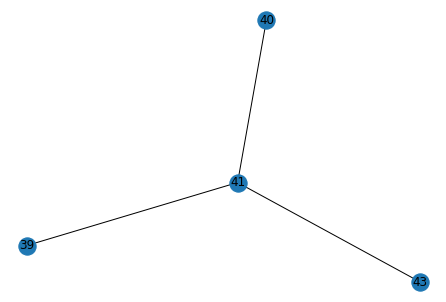

match_branches = [[39, 43]]
edges_to_delete (resolve crossover) = [[39, 40], [39, 41], [40, 41], [40, 43], [41, 43]]
edges_to_create (resolve crossover) = [[39, 43]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[39, 40], [39, 41], [40, 41], [40, 43], [41, 43]]
edges_to_create = [[39, 43]]
Number of connected components = 6
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 37, 38, 41, 44, 45, 49, 50, 51, 52, 53, 54, 55, 57, 59, 61, 63, 64, 65, 67, 69, 70, 73, 77, 81, 82, 83, 88, 89, 90, 91, 92, 94, 95, 97, 98, 103, 104, 105}
Comp 1 = {8, 32, 33, 34, 35, 36, 39, 43, 46, 47, 48, 60, 62, 66, 68, 71, 72, 74, 75, 76, 78, 79, 80, 84, 85, 86, 87, 93, 96, 99, 100, 101, 102}
Comp 2 = {40}
Comp 3 = {42}
Comp 4 = {56}
Comp 5 = {58}
curr_limb_copy.deleted_edges = [[39, 40], [39, 41], [40, 41], [40, 43], [41, 43]]
curr_limb_copy.created_edges = [[39, 43]]
After get best cut: cut_edges = 

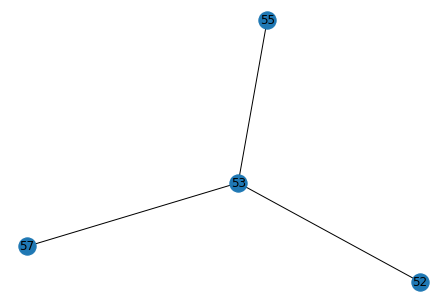

match_branches = [[52, 55]]
edges_to_delete (resolve crossover) = [[52, 53], [52, 57], [53, 55], [53, 57], [55, 57]]
edges_to_create (resolve crossover) = [[52, 55]]
curr_limb.deleted_edges 5 =[[39, 40], [39, 41], [40, 41], [40, 43], [41, 43]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[52, 53], [52, 57], [53, 55], [53, 57], [55, 57]]
edges_to_create = [[52, 55]]
Number of connected components = 8
Comp 0 = {52, 55}
Comp 1 = {0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 37, 38, 41, 44, 45, 49, 50, 51, 53, 54, 64, 65, 67, 69, 70, 73, 77, 81, 82, 83, 90, 91, 92, 94, 95, 97, 98, 103, 104, 105}
Comp 2 = {89, 88, 57, 59, 61, 63}
Comp 3 = {8, 32, 33, 34, 35, 36, 39, 43, 46, 47, 48, 60, 62, 66, 68, 71, 72, 74, 75, 76, 78, 79, 80, 84, 85, 86, 87, 93, 96, 99, 100, 101, 102}
Comp 4 = {40}
Comp 5 = {42}
Comp 6 = {56}
Comp 7 = {58}
curr_limb_copy.deleted_edges = [[39, 40], [39, 41], [40, 41], [40, 43], [41, 43], [52, 5

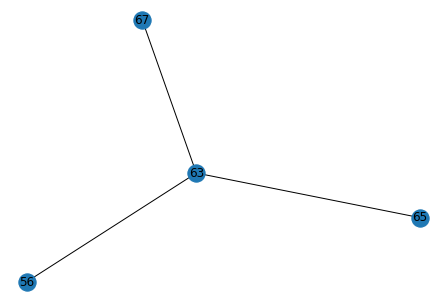

match_branches = [[63, 65], [56, 67]]
edges_to_delete (resolve crossover) = [[56, 63], [56, 65], [63, 67], [65, 67]]
edges_to_create (resolve crossover) = [[63, 65], [56, 67]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 18 because skeletal distance was 164.88555049397638 and threshold was 2500
skip_nodes = [18]
edges_to_delete (cut_limb_network) = [[56, 63], [56, 65], [63, 67], [65, 67]]
edges_to_create = [[63, 65], [56, 67]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108}
Comp 1 = {56, 67}
curr_limb_copy.deleted_edges = [[56, 63], [56, 65], [63, 67], [65, 67]]
curr_

  Edge: [17 14]: curr_angle = 21.62
  Edge: [14 15]: curr_angle = 17.4
  Edge: [15 20]: curr_angle = 19.05
  Edge: [20 21]: curr_angle = 12.07
  Edge: [21 22]: curr_angle = 37.64
  Edge: [22 24]: curr_angle = 22.71
  Edge: [24 31]: curr_angle = 4.02
  Edge: [31 36]: curr_angle = 19.2
  Edge: [36 43]: curr_angle = 36.96
  Edge: [43 47]: curr_angle = 37.35
  Edge: [47 54]: curr_angle = 38.5
  Edge: [54 63]: curr_angle = 32.05
  Edge: [63 65]: curr_angle = 1.91
  Edge: [65 66]: curr_angle = 20.36
  Edge: [66 62]: curr_angle = 22.42
  Edge: [62 61]: curr_angle = 23.76
  Edge: [61 68]: curr_angle = 22.95

Total time for doubling_back = 0.7862350940704346

Attempting the width jump check (attempting from both sides)
  Edge: [17 14]: jump = -559.58
  Edge: [14 15]: jump = -92.57
  Edge: [15 20]: jump = 3.23
  Edge: [20 21]: jump = -127.61
  Edge: [21 22]: jump = -83.87
  Edge: [22 24]: jump = -197.19
  Edge: [24 31]: jump = -157.67
  Edge: [31 36]: jump = -105.81
  Edge: [36 43]: jump = 40.68

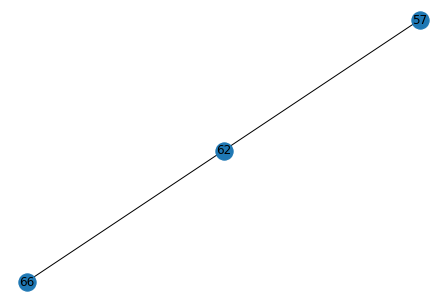

match_branches = [[62, 66]]
edges_to_delete (resolve crossover) = [[57, 62], [57, 66]]
edges_to_create (resolve crossover) = [[62, 66]]
Rejecting creating edge [62, 66] becuase did not involve only 1 node in the deleted edge
edges_to_delete (cut_limb_network) = [array([57, 62]), array([57, 66]), array([62, 66])]
edges_to_create = []
Number of connected components = 4
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 60, 63, 64, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108}
Comp 1 = {56, 67}
Comp 2 = {57}
Comp 3 = {68, 40, 41, 42, 51, 52, 53, 58, 59, 61, 62}
curr_limb_copy.deleted_edges = [[56, 63], [56, 65], [63, 67], [65, 67], array([57, 62]), array([57, 66]), array([62, 66])]
curr_limb_copy.created_edges = [

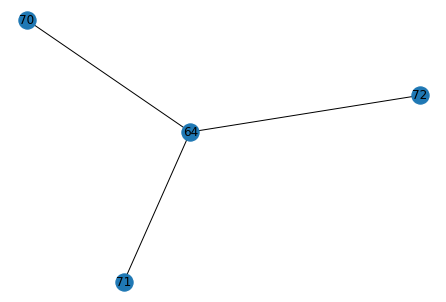

match_branches = [[64, 72]]
edges_to_delete (resolve crossover) = [[64, 70], [64, 71], [70, 71], [70, 72], [71, 72]]
edges_to_create (resolve crossover) = [[64, 72]]
curr_limb.deleted_edges 5 =[[56, 63], [56, 65], [63, 67], [65, 67], array([57, 62]), array([57, 66]), array([62, 66])]
Skipping endnode 18 because skeletal distance was 164.88555049397638 and threshold was 2500
skip_nodes = [18]
edges_to_delete (cut_limb_network) = [[64, 70], [64, 71], [70, 71], [70, 72], [71, 72]]
edges_to_create = [[64, 72]]
Number of connected components = 6
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 43, 44, 45, 46, 47, 48, 49, 50, 54, 55, 60, 63, 64, 65, 66, 69, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108}
Comp 1 = {56, 67}
Comp 2 = {70}
Comp 3 = {71}
Comp 4 = {57}
Comp 5 = {68

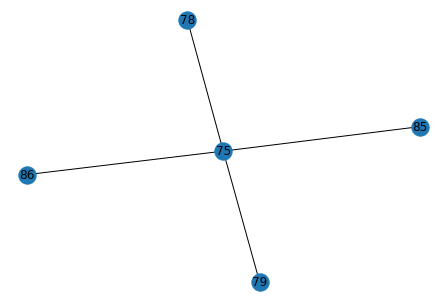

match_branches = [[85, 86]]
edges_to_delete (resolve crossover) = [[75, 78], [75, 79], [75, 85], [75, 86], [78, 79], [78, 85], [78, 86], [79, 85], [79, 86]]
edges_to_create (resolve crossover) = [[85, 86]]
curr_limb.deleted_edges 5 =[[56, 63], [56, 65], [63, 67], [65, 67], array([57, 62]), array([57, 66]), array([62, 66]), [64, 70], [64, 71], [70, 71], [70, 72], [71, 72]]
Skipping endnode 18 because skeletal distance was 164.88555049397638 and threshold was 2500
skip_nodes = [18]
edges_to_delete (cut_limb_network) = [[75, 78], [75, 79], [75, 85], [75, 86], [78, 79], [78, 85], [78, 86], [79, 85], [79, 86]]
edges_to_create = [[85, 86]]
Number of connected components = 9
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 43, 44, 45, 46, 47, 48, 49, 50, 54, 60, 63, 64, 65, 66, 72, 74, 75}
Comp 1 = {56, 67}
Comp 2 = {70}
Comp 3 = {71}
Comp 4 = {57}
Comp 5 = {68, 40, 41, 42, 51, 52, 5

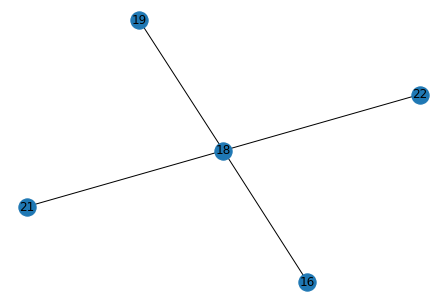

match_branches = [[18, 19], [16, 21]]
edges_to_delete (resolve crossover) = [[16, 18], [16, 19], [16, 22], [18, 21], [18, 22], [19, 21], [19, 22], [21, 22]]
edges_to_create (resolve crossover) = [[18, 19], [16, 21]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[16, 18], [16, 19], [16, 22], [18, 21], [18, 22], [19, 21], [19, 22], [21, 22]]
edges_to_create = [[18, 19], [16, 21]]
Number of connected components = 3
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 23, 27, 28, 30, 31, 33, 34, 36, 37, 40, 42, 45, 46, 47, 57, 58, 59, 60, 61, 62, 63, 64, 65, 68, 76, 81, 88, 92, 93.0, 94, 95, 96, 98, 99, 100, 102, 103, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 124, 125, 131, 133, 142, 143, 144, 145, 146, 147, 148, 149, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172}
Comp 1 = {128, 129, 130, 132, 134, 135, 136, 137, 138, 139, 140, 141, 16, 21, 150, 151, 152, 153, 26, 155, 156, 29, 157, 25

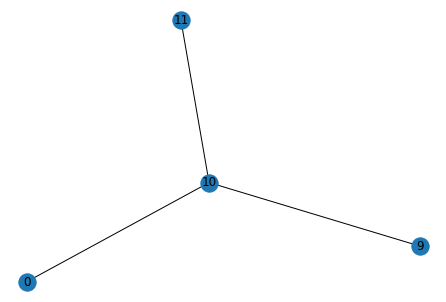

match_branches = [[0, 11]]
edges_to_delete (resolve crossover) = [[0, 9], [0, 10], [9, 10], [9, 11], [10, 11]]
edges_to_create (resolve crossover) = [[0, 11]]
curr_limb.deleted_edges 5 =[[16, 18], [16, 19], [16, 22], [18, 21], [18, 22], [19, 21], [19, 22], [21, 22]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[0, 9], [0, 10], [9, 10], [9, 11], [10, 11]]
edges_to_create = [[0, 11]]
Number of connected components = 3
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 23, 27, 28, 30, 31, 33, 34, 36, 37, 40, 42, 45, 46, 47, 57, 58, 59, 60, 61, 62, 63, 64, 65, 68, 76, 81, 88, 92, 93.0, 94, 95, 96, 98, 99, 100, 102, 103, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 124, 125, 131, 133, 142, 143, 144, 145, 146, 147, 148, 149, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172}
Comp 1 = {128, 129, 130, 132, 134, 135, 136, 137, 138, 139, 140, 141, 16, 21, 150, 151, 152, 153, 26, 155, 156, 29, 157, 25, 32, 154, 35, 38, 39, 41

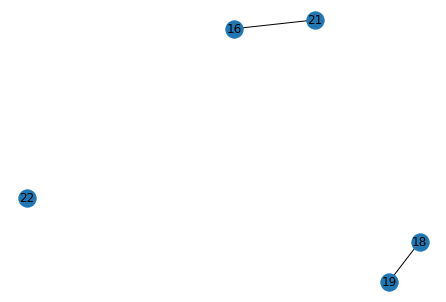

match_branches = [[18, 19], [16, 21]]
edges_to_delete (resolve crossover) = [[16, 18], [16, 19], [16, 22], [18, 21], [18, 22], [19, 21], [19, 22], [21, 22]]
edges_to_create (resolve crossover) = [[18, 19], [16, 21]]
curr_limb.deleted_edges 5 =[[16, 18], [16, 19], [16, 22], [18, 21], [18, 22], [19, 21], [19, 22], [21, 22], [0, 9], [0, 10], [9, 10], [9, 11], [10, 11]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[16, 18], [16, 19], [16, 22], [18, 21], [18, 22], [19, 21], [19, 22], [21, 22]]
edges_to_create = [[18, 19], [16, 21]]
Number of connected components = 3
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 23, 27, 28, 30, 31, 33, 34, 36, 37, 40, 42, 45, 46, 47, 57, 58, 59, 60, 61, 62, 63, 64, 65, 68, 76, 81, 88, 92, 93.0, 94, 95, 96, 98, 99, 100, 102, 103, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 124, 125, 131, 133, 142, 143, 144, 145, 146, 147, 148, 149, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172}


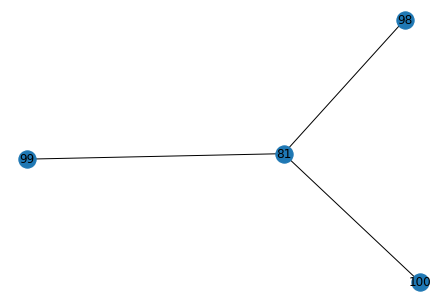

match_branches = [[98, 100]]
edges_to_delete (resolve crossover) = [[81, 98], [81, 99], [81, 100], [98, 99], [99, 100]]
edges_to_create (resolve crossover) = [[98, 100]]
curr_limb.deleted_edges 5 =[[16, 18], [16, 19], [16, 22], [18, 21], [18, 22], [19, 21], [19, 22], [21, 22], [0, 9], [0, 10], [9, 10], [9, 11], [10, 11], [16, 18], [16, 19], [16, 22], [18, 21], [18, 22], [19, 21], [19, 22], [21, 22]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[81, 98], [81, 99], [81, 100], [98, 99], [99, 100]]
edges_to_create = [[98, 100]]
Number of connected components = 5
Comp 0 = {1, 131, 3, 133, 5, 6, 4, 10, 12, 142, 143, 144, 145, 146, 147, 148, 149, 20, 23, 19, 18, 17, 27, 28, 158, 159, 160, 33, 34, 163, 164, 162, 161, 167, 40, 169, 42, 170, 171, 45, 46, 168, 172, 57, 58, 61, 62, 63, 64, 65, 165, 166, 88, 92, 93.0, 95, 96, 98, 100, 102, 103, 106, 107, 108, 109, 110, 113, 124, 125}
Comp 1 = {0, 2, 68, 37, 36, 7, 8, 9, 11, 76, 13, 14, 15, 47, 81, 59, 60, 30, 31}
Comp 2 = {99, 111, 112, 11

  Edge: [17 18]: curr_angle = 24.94
  Edge: [18 19]: curr_angle = 4.12
  Edge: [19 20]: curr_angle = 35.0
  Edge: [20 23]: curr_angle = 34.7
  Edge: [23 27]: curr_angle = 16.67
  Edge: [27 40]: curr_angle = 34.22
  Edge: [40 57]: curr_angle = 167.36
  Edge: [57 65]: curr_angle = 29.9
  Edge: [ 65 106]: curr_angle = 26.83
  Edge: [106 108]: curr_angle = 34.52
  Edge: [108 102]: curr_angle = 20.45
  Edge: [102 100]: curr_angle = 12.8
  Edge: [100  98]: curr_angle = 10.96

Total time for doubling_back = 0.9303605556488037
There were 1 edges that passed doubling back threshold of 100
Winning edge [40 57] had a doubling back of 167.36027492811897
***inside resolve crossover!!!!****
coordinate_branches = [40, 57, 62]
40 = red
57 = aqua
62 = purple
Angle between 40 and 57 = 159.77 
Angle between 40 and 62 = 29.86 
Angle between 57 and 62 = 23.73 
Final Matches = [[40, 62], [57, 62]]
matched_branches_revised = [[57, 62]]
Original graph


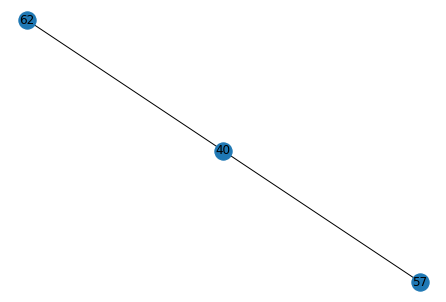

match_branches = [[57, 62]]
edges_to_delete (resolve crossover) = [[40, 57], [40, 62]]
edges_to_create (resolve crossover) = [[57, 62]]
edges_to_delete (cut_limb_network) = [array([40, 57]), array([40, 62])]
edges_to_create = [[57, 62]]
Number of connected components = 6
Comp 0 = {131, 133, 142, 143, 144, 145, 146, 147, 148, 149, 158, 159, 160, 33, 34, 163, 164, 161, 162, 167, 168, 169, 170, 171, 172, 45, 46, 166, 57, 58, 61, 62, 63, 64, 65, 165, 98, 100, 102, 103, 106, 107, 108, 109, 110, 113, 124, 125}
Comp 1 = {0, 2, 68, 37, 36, 7, 8, 9, 11, 76, 13, 14, 15, 47, 81, 59, 60, 30, 31}
Comp 2 = {99, 111, 112, 114, 115, 116, 94}
Comp 3 = {1, 3, 4, 5, 6, 10, 12, 17, 18, 19, 20, 23, 27, 28, 40, 42, 88, 92, 93.0, 95, 96}
Comp 4 = {128, 129, 130, 132, 134, 135, 136, 137, 138, 139, 140, 141, 16, 21, 150, 151, 152, 153, 26, 155, 156, 29, 157, 25, 32, 154, 35, 38, 39, 41, 43, 44, 173, 174, 48, 49, 50, 51, 52, 53, 54, 55, 56, 66, 67, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 82, 83, 84, 85, 86,

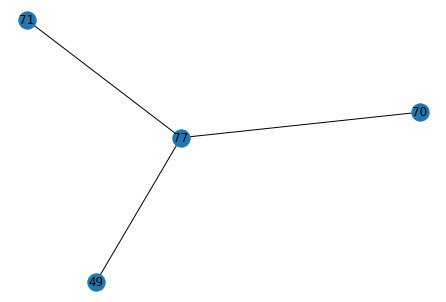

match_branches = [[49, 77]]
edges_to_delete (resolve crossover) = [[49, 70], [49, 71], [70, 71], [70, 77], [71, 77]]
edges_to_create (resolve crossover) = [[49, 77]]
curr_limb.deleted_edges 5 =[[16, 18], [16, 19], [16, 22], [18, 21], [18, 22], [19, 21], [19, 22], [21, 22], [0, 9], [0, 10], [9, 10], [9, 11], [10, 11], [16, 18], [16, 19], [16, 22], [18, 21], [18, 22], [19, 21], [19, 22], [21, 22], [81, 98], [81, 99], [81, 100], [98, 99], [99, 100], array([40, 57]), array([40, 62])]
Skipping endnode 136 because skeletal distance was 1252.7731364647534 and threshold was 2500
skip_nodes = [136]
edges_to_delete (cut_limb_network) = [[49, 70], [49, 71], [70, 71], [70, 77], [71, 77]]
edges_to_create = [[49, 77]]
Number of connected components = 9
Comp 0 = {131, 133, 142, 143, 144, 145, 146, 147, 148, 149, 158, 159, 160, 33, 34, 163, 164, 161, 162, 167, 168, 169, 170, 171, 172, 45, 46, 166, 57, 58, 61, 62, 63, 64, 65, 165, 98, 100, 102, 103, 106, 107, 108, 109, 110, 113, 124, 125}
Comp 1 = {0, 

  Edge: [0 3]: curr_angle = 15.54
  Edge: [3 6]: curr_angle = 12.75
  Edge: [6 8]: curr_angle = 24.02
  Edge: [ 8 14]: curr_angle = 52.59
  Edge: [14 13]: curr_angle = 105.32
  Edge: [13 11]: curr_angle = 6.8
  Edge: [11 10]: curr_angle = 30.6

Total time for doubling_back = 0.5891485214233398
There were 1 edges that passed doubling back threshold of 100
Winning edge [14 13] had a doubling back of 105.31583614126406
***inside resolve crossover!!!!****
coordinate_branches = [13, 14, 16]
13 = red
14 = aqua
16 = purple
Angle between 13 and 14 = 107.56 
Angle between 13 and 16 = 22.92 
Angle between 14 and 16 = 61.66 
Final Matches = [[13, 16]]
matched_branches_revised = [[13, 16]]
Original graph


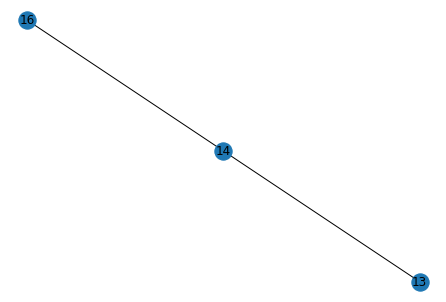

match_branches = [[13, 16]]
edges_to_delete (resolve crossover) = [[13, 14], [14, 16]]
edges_to_create (resolve crossover) = [[13, 16]]
edges_to_delete (cut_limb_network) = [array([13, 14]), array([14, 16])]
edges_to_create = [[13, 16]]
Number of connected components = 2
Comp 0 = {0, 2, 3, 5, 6, 7, 8, 14, 15}
Comp 1 = {1, 4, 9, 10, 11, 12, 13, 16}
curr_limb_copy.deleted_edges = [array([13, 14]), array([14, 16])]
curr_limb_copy.created_edges = [[13, 16]]
After get best cut: cut_edges = [array([13, 14]), array([14, 16])], added_edges = [[13, 16]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([ 0,  2,  3,  5,  6,  7,  8, 14, 15]), array([ 1,  4,  9, 10, 11, 12, 13, 16])]


 ------ Total time for Splitting 864691

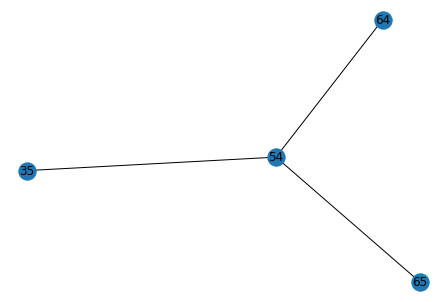

match_branches = [[54, 64]]
edges_to_delete (resolve crossover) = [[35, 54], [35, 64], [35, 65], [54, 65], [64, 65]]
edges_to_create (resolve crossover) = [[54, 64]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[35, 54], [35, 64], [35, 65], [54, 65], [64, 65]]
edges_to_create = [[54, 64]]
Number of connected components = 4
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11.0, 12, 13, 14.0, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 66, 67, 68, 69, 70, 71, 72, 73.0, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95}
Comp 1 = {35}
Comp 2 = {65}
Comp 3 = {63}
curr_limb_copy.deleted_edges = [[35, 54], [35, 64], [35, 65], [54, 65], [64, 65]]
curr_limb_copy.created_edges = [[54, 64]]
After get best cut: cut_edges = [[35, 54], [35, 64], [35, 65], [54, 65], [64, 65]], added_ed

  Edge: [45 46]: curr_angle = 25.87
  Edge: [46 49]: curr_angle = 29.15
  Edge: [49 60]: curr_angle = 16.89
  Edge: [60 59]: curr_angle = 22.05
  Edge: [59 47]: curr_angle = 46.35
  Edge: [47 30]: curr_angle = 27.11
  Edge: [30 21]: curr_angle = 26.63
  Edge: [21 20]: curr_angle = 158.33
  Edge: [20 25]: curr_angle = 17.45
  Edge: [25 34]: curr_angle = 51.14
  Edge: [34 52]: curr_angle = 48.53
  Edge: [52 50]: curr_angle = 5.87
  Edge: [50 51]: curr_angle = 30.9
  Edge: [51 54]: curr_angle = 7.07
  Edge: [54 64]: curr_angle = 9.13
  Edge: [64 66]: curr_angle = 26.27

Total time for doubling_back = 1.0303564071655273
There were 1 edges that passed doubling back threshold of 100
Winning edge [21 20] had a doubling back of 158.3287134652743
***inside resolve crossover!!!!****
coordinate_branches = [18, 20, 21]
18 = red
20 = aqua
21 = purple
Angle between 18 and 20 = 15.76 
Angle between 18 and 21 = 9.83 
Angle between 20 and 21 = 155.01 
Final Matches = [[18, 20], [18, 21]]
matched_branch

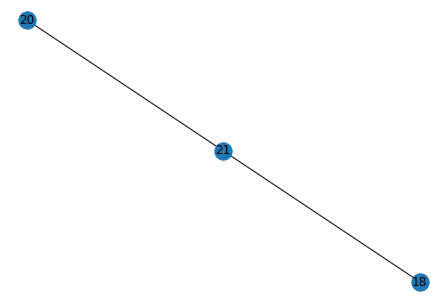

match_branches = [[18, 21]]
edges_to_delete (resolve crossover) = [[18, 20], [20, 21]]
edges_to_create (resolve crossover) = [[18, 21]]
edges_to_delete (cut_limb_network) = [array([18, 20]), array([20, 21])]
edges_to_create = [[18, 21]]
Number of connected components = 5
Comp 0 = {0, 1, 2, 4, 7, 9, 20, 22, 24, 25, 26, 27, 28, 29, 32, 33, 34, 36, 37, 38, 41, 50, 51, 52, 54, 55, 56, 61, 64, 66, 68, 69, 70, 71, 72, 73.0, 74, 75, 76, 77, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 93, 94, 95}
Comp 1 = {35}
Comp 2 = {65}
Comp 3 = {3, 5, 6, 8, 10, 11.0, 12, 13, 14.0, 15, 16, 17, 18, 19, 21, 23, 30, 31, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 53, 57, 58, 59, 60, 62, 67, 78, 79, 80, 91, 92}
Comp 4 = {63}
curr_limb_copy.deleted_edges = [[35, 54], [35, 64], [35, 65], [54, 65], [64, 65], array([18, 20]), array([20, 21])]
curr_limb_copy.created_edges = [[54, 64], [18, 21]]
After get best cut: cut_edges = [array([18, 20]), array([20, 21])], added_edges = [[18, 21]]
total_soma_paths_to_cut = [[35, 54], 

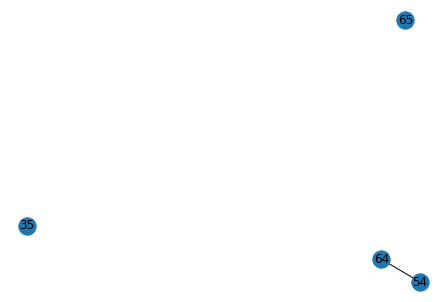

match_branches = [[54, 64]]
edges_to_delete (resolve crossover) = [[35, 54], [35, 64], [35, 65], [54, 65], [64, 65]]
edges_to_create (resolve crossover) = [[54, 64]]
curr_limb.deleted_edges 5 =[[35, 54], [35, 64], [35, 65], [54, 65], [64, 65], array([18, 20]), array([20, 21])]
Skipping endnode 95 because skeletal distance was 2293.7196987579687 and threshold was 2500
skip_nodes = [95]
edges_to_delete (cut_limb_network) = [[35, 54], [35, 64], [35, 65], [54, 65], [64, 65]]
edges_to_create = [[54, 64]]
Number of connected components = 5
Comp 0 = {0, 1, 2, 4, 7, 9, 20, 22, 24, 25, 26, 27, 28, 29, 32, 33, 34, 36, 37, 38, 41, 50, 51, 52, 54, 55, 56, 61, 64, 66, 68, 69, 70, 71, 72, 73.0, 74, 75, 76, 77, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 93, 94, 95}
Comp 1 = {35}
Comp 2 = {65}
Comp 3 = {3, 5, 6, 8, 10, 11.0, 12, 13, 14.0, 15, 16, 17, 18, 19, 21, 23, 30, 31, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 53, 57, 58, 59, 60, 62, 67, 78, 79, 80, 91, 92}
Comp 4 = {63}
curr_limb_copy.deleted_edges =

  Edge: [66 64]: curr_angle = 26.27
  Edge: [64 54]: curr_angle = 9.13
  Edge: [54 51]: curr_angle = 33.25
  Edge: [51 50]: curr_angle = 10.46
  Edge: [50 52]: curr_angle = 5.87
  Edge: [52 56]: curr_angle = 25.02
  Edge: [56 61]: curr_angle = 41.22
  Edge: [61 81]: curr_angle = 36.6
  Edge: [81 82]: curr_angle = 18.95
  Edge: [82 83]: curr_angle = 39.76
  Edge: [83 90]: curr_angle = 32.16
  Edge: [90 93]: curr_angle = 25.83

Total time for doubling_back = 1.9401342868804932

Attempting the width jump check (attempting from both sides)
  Edge: [66 64]: jump = -204.98
  Edge: [64 54]: jump = 5.57
  Edge: [54 51]: jump = -189.13
  Edge: [51 50]: jump = -14.5
  Edge: [50 52]: jump = -134.54
  Edge: [52 56]: jump = -166.22
  Edge: [56 61]: jump = -321.35
  Edge: [61 81]: jump = -39.5
  Edge: [81 82]: jump = 289.8
Adding error edge [81 82] because width jump was 289.799592723701
  Edge: [82 83]: jump = 52.96
  Edge: [83 90]: jump = 100.37
  Edge: [90 93]: jump = 185.96
Total time for width 

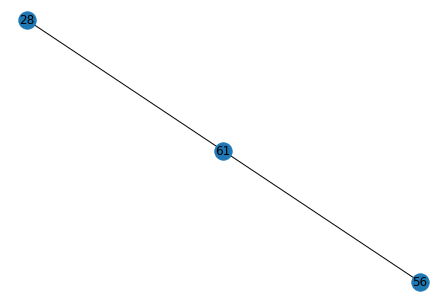

match_branches = [[28, 56]]
edges_to_delete (resolve crossover) = [[28, 61], [56, 61]]
edges_to_create (resolve crossover) = [[28, 56]]
edges_to_delete (cut_limb_network) = [array([28, 61]), array([56, 61])]
edges_to_create = [[28, 56]]
Number of connected components = 6
Comp 0 = {0, 1, 4, 7, 9, 20, 22, 24, 25, 27, 28, 29, 32, 33, 34, 36, 37, 38, 41, 50, 51, 52, 54, 56, 64, 66, 68, 69, 70, 71, 72, 73.0, 84, 85, 88, 89}
Comp 1 = {35}
Comp 2 = {65}
Comp 3 = {2, 26, 74, 75, 76, 77, 81, 82, 83, 93, 86, 55, 87, 90, 61, 94, 95}
Comp 4 = {3, 5, 6, 8, 10, 11.0, 12, 13, 14.0, 15, 16, 17, 18, 19, 21, 23, 30, 31, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 53, 57, 58, 59, 60, 62, 67, 78, 79, 80, 91, 92}
Comp 5 = {63}
curr_limb_copy.deleted_edges = [[35, 54], [35, 64], [35, 65], [54, 65], [64, 65], array([18, 20]), array([20, 21]), [35, 54], [35, 64], [35, 65], [54, 65], [64, 65], array([28, 61]), array([56, 61])]
curr_limb_copy.created_edges = [[54, 64], [18, 21], [54, 64], [28, 56]]
After get best c

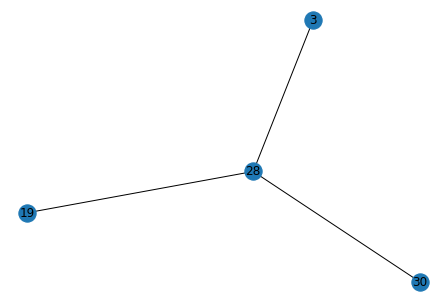

match_branches = [[3, 30], [19, 28]]
edges_to_delete (resolve crossover) = [[3, 19], [3, 28], [19, 30], [28, 30]]
edges_to_create (resolve crossover) = [[3, 30], [19, 28]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[3, 19], [3, 28], [19, 30], [28, 30]]
edges_to_create = [[3, 30], [19, 28]]
Number of connected components = 3
Comp 0 = {0, 1, 2, 4, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 32, 33, 34, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,

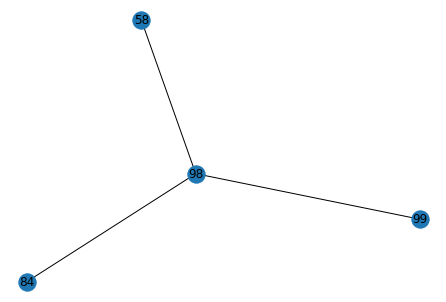

match_branches = [[58, 99]]
edges_to_delete (resolve crossover) = [[58, 84], [58, 98], [84, 98], [84, 99], [98, 99]]
edges_to_create (resolve crossover) = [[58, 99]]
curr_limb.deleted_edges 5 =[[3, 19], [3, 28], [19, 30], [28, 30]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[58, 84], [58, 98], [84, 98], [84, 99], [98, 99]]
edges_to_create = [[58, 99]]
Number of connected components = 7
Comp 0 = {0, 1, 2, 4, 10, 11, 12, 13, 16, 18, 19, 20, 21, 23, 24, 25, 28, 29, 32, 33, 34, 38, 41, 42, 43, 46, 47, 50, 52, 59, 61, 63, 64, 65, 66, 70, 71, 72, 73, 74, 75, 76, 77, 81, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 1

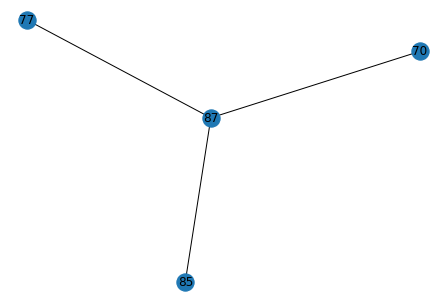

match_branches = [[70, 85]]
edges_to_delete (resolve crossover) = [[70, 77], [70, 87], [77, 85], [77, 87], [85, 87]]
edges_to_create (resolve crossover) = [[70, 85]]
curr_limb.deleted_edges 5 =[[3, 19], [3, 28], [19, 30], [28, 30], [58, 84], [58, 98], [84, 98], [84, 99], [98, 99]]
Skipping endnode 85 because skeletal distance was 794.5063228640839 and threshold was 2500
skip_nodes = [85]
edges_to_delete (cut_limb_network) = [[70, 77], [70, 87], [77, 85], [77, 87], [85, 87]]
edges_to_create = [[70, 85]]
Number of connected components = 8
Comp 0 = {0, 1, 2, 4, 10, 11, 13, 16, 18, 19, 20, 21, 23, 24, 25, 28, 29, 32, 33, 34, 38, 41, 42, 43, 46, 47, 50, 52, 59, 61, 63, 64, 65, 66, 70, 71, 72, 73, 74, 75, 76, 81, 85, 86, 87, 90, 91, 92, 93, 94, 95, 98, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149, 150, 151

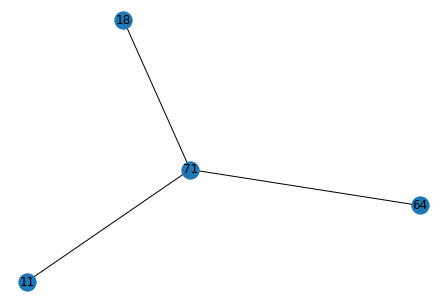

match_branches = [[11, 71]]
edges_to_delete (resolve crossover) = [[11, 18], [11, 64], [18, 64], [18, 71], [64, 71]]
edges_to_create (resolve crossover) = [[11, 71]]
curr_limb.deleted_edges 5 =[[3, 19], [3, 28], [19, 30], [28, 30], [58, 84], [58, 98], [84, 98], [84, 99], [98, 99], [70, 77], [70, 87], [77, 85], [77, 87], [85, 87]]
Skipping endnode 85 because skeletal distance was 794.5063228640839 and threshold was 2500
skip_nodes = [85]
edges_to_delete (cut_limb_network) = [[11, 18], [11, 64], [18, 64], [18, 71], [64, 71]]
edges_to_create = [[11, 71]]
Number of connected components = 11
Comp 0 = {1, 2, 4, 10, 11, 13, 16, 19, 20, 21, 23, 25, 28, 29, 32, 33, 34, 38, 41, 43, 46, 47, 50, 63, 71, 86, 87, 90, 91, 93, 94, 98, 100, 101, 103, 105, 108, 109, 110, 111, 112, 113, 114, 115, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 142, 143, 144, 145, 146, 147, 149, 150, 152, 154, 155, 156, 157, 158, 159, 162, 163, 168, 169, 173, 1

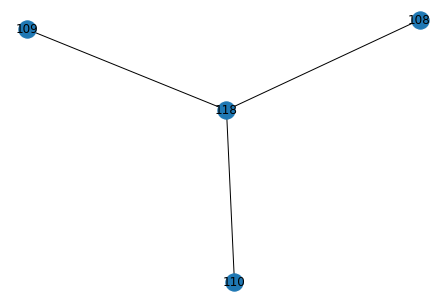

match_branches = []
edges_to_delete (resolve crossover) = [[108, 109], [108, 110], [108, 118], [109, 110], [109, 118], [110, 118]]
edges_to_create (resolve crossover) = []
curr_limb.deleted_edges 5 =[[3, 19], [3, 28], [19, 30], [28, 30], [58, 84], [58, 98], [84, 98], [84, 99], [98, 99], [70, 77], [70, 87], [77, 85], [77, 87], [85, 87], [11, 18], [11, 64], [18, 64], [18, 71], [64, 71]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[108, 109], [108, 110], [108, 118], [109, 110], [109, 118], [110, 118]]
edges_to_create = []
Number of connected components = 13
Comp 0 = {1, 2, 4, 10, 11, 13, 19, 20, 21, 23, 25, 28, 29, 32, 33, 34, 38, 41, 43, 46, 47, 50, 63, 71, 86, 87, 90, 91, 94, 98, 101, 103, 105, 108, 112, 113, 114, 118, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 133, 134, 136, 138, 139, 140, 142, 143, 144, 145, 146, 147, 149, 150, 152, 154, 155, 156, 159, 162, 163, 168, 169, 173, 175, 176, 180, 181, 184, 188, 189, 190, 193, 197, 198, 200, 201, 202, 203, 206, 210, 211, 21

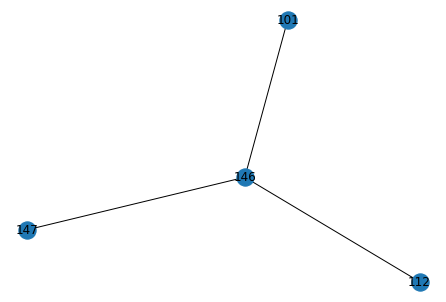

match_branches = [[101, 147], [112, 146]]
edges_to_delete (resolve crossover) = [[101, 112], [101, 146], [112, 147], [146, 147]]
edges_to_create (resolve crossover) = [[101, 147], [112, 146]]
curr_limb.deleted_edges 5 =[[3, 19], [3, 28], [19, 30], [28, 30], [58, 84], [58, 98], [84, 98], [84, 99], [98, 99], [70, 77], [70, 87], [77, 85], [77, 87], [85, 87], [11, 18], [11, 64], [18, 64], [18, 71], [64, 71], [108, 109], [108, 110], [108, 118], [109, 110], [109, 118], [110, 118]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[101, 112], [101, 146], [112, 147], [146, 147]]
edges_to_create = [[101, 147], [112, 146]]
Number of connected components = 14
Comp 0 = {1, 2, 4, 10, 13, 19, 20, 21, 147, 23, 25, 28, 32, 33, 34, 38, 41, 43, 46, 47, 50, 63, 94, 98, 101, 103, 108}
Comp 1 = {3, 35, 37, 6, 8, 49, 17, 26, 30, 31}
Comp 2 = {109}
Comp 3 = {131, 100, 132, 137, 204, 205, 110, 111, 16, 179, 115, 93, 214, 119, 120, 213, 157, 158}
Comp 4 = {128, 129, 130, 133, 134, 136, 138, 11, 139, 140, 1

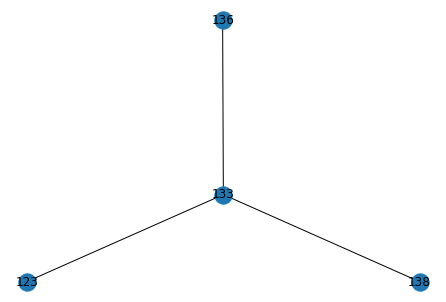

match_branches = []
edges_to_delete (resolve crossover) = [[123, 133], [123, 136], [123, 138], [133, 136], [133, 138], [136, 138]]
edges_to_create (resolve crossover) = []
curr_limb.deleted_edges 5 =[[3, 19], [3, 28], [19, 30], [28, 30], [58, 84], [58, 98], [84, 98], [84, 99], [98, 99], [70, 77], [70, 87], [77, 85], [77, 87], [85, 87], [11, 18], [11, 64], [18, 64], [18, 71], [64, 71], [108, 109], [108, 110], [108, 118], [109, 110], [109, 118], [110, 118], [101, 112], [101, 146], [112, 147], [146, 147]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[123, 133], [123, 136], [123, 138], [133, 136], [133, 138], [136, 138]]
edges_to_create = []
Number of connected components = 17
Comp 0 = {1, 2, 4, 10, 13, 19, 20, 21, 147, 23, 25, 28, 32, 33, 34, 38, 41, 43, 46, 47, 50, 63, 94, 98, 101, 103, 108}
Comp 1 = {3, 35, 37, 6, 8, 49, 17, 26, 30, 31}
Comp 2 = {109}
Comp 3 = {131, 100, 132, 137, 204, 205, 110, 111, 16, 179, 115, 93, 214, 119, 120, 213, 157, 158}
Comp 4 = {128, 129, 130, 133, 

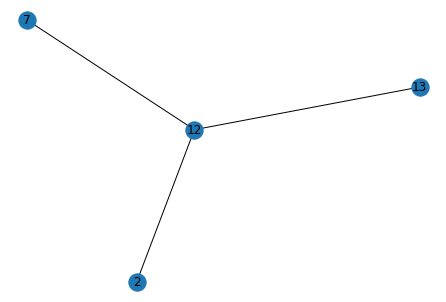

match_branches = [[2, 12]]
edges_to_delete (resolve crossover) = [[2, 7], [2, 13], [7, 12], [7, 13], [12, 13]]
edges_to_create (resolve crossover) = [[2, 12]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[2, 7], [2, 13], [7, 12], [7, 13], [12, 13]]
edges_to_create = [[2, 12]]
Number of connected components = 3
Comp 0 = {0, 1, 2, 3, 5, 6, 8, 9, 11, 12, 14, 15, 17, 18, 19, 20, 27, 28, 33, 34, 36, 37, 48, 49, 63, 67, 69, 70, 71, 72}
Comp 1 = {7}
Comp 2 = {4, 10, 13, 16, 21, 22, 23, 24, 25, 26, 29, 30, 31, 32, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 68, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88}
curr_limb_copy.deleted_edges = [[2, 7], [2, 13], [7, 12], [7, 13], [12, 13]]
curr_limb_copy.created_edges = [[2, 12]]
After get best cut: cut_edges = [[2, 7], [2, 13], [7, 12], [7, 13], [12, 13]], added_edges = [[2, 12]]
total_soma_paths_to_cut = []
-----------counter = 0-

  Edge: [37 34]: curr_angle = 68.25
  Edge: [34 33]: curr_angle = 125.56
  Edge: [33 63]: curr_angle = 43.94

Total time for doubling_back = 0.12681269645690918
There were 1 edges that passed doubling back threshold of 100
Winning edge [34 33] had a doubling back of 125.56411869155237
***inside resolve crossover!!!!****
coordinate_branches = [28, 33, 34]
28 = red
33 = aqua
34 = purple
Angle between 28 and 33 = 11.14 
Angle between 28 and 34 = 52.68 
Angle between 33 and 34 = 124.64 
Final Matches = [[28, 33]]
matched_branches_revised = [[28, 33]]
Original graph


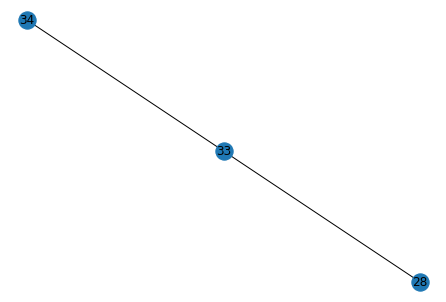

match_branches = [[28, 33]]
edges_to_delete (resolve crossover) = [[28, 34], [33, 34]]
edges_to_create (resolve crossover) = [[28, 33]]
edges_to_delete (cut_limb_network) = [array([28, 34]), array([33, 34])]
edges_to_create = [[28, 33]]
Number of connected components = 4
Comp 0 = {0, 1, 2, 5, 6, 8, 9, 11, 12, 14, 15, 17, 18, 19, 20, 27, 28, 33, 36, 48, 49, 63, 67, 69, 70, 71, 72}
Comp 1 = {34, 3, 37}
Comp 2 = {7}
Comp 3 = {4, 10, 13, 16, 21, 22, 23, 24, 25, 26, 29, 30, 31, 32, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 68, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88}
curr_limb_copy.deleted_edges = [[2, 7], [2, 13], [7, 12], [7, 13], [12, 13], array([28, 34]), array([33, 34])]
curr_limb_copy.created_edges = [[2, 12], [28, 33]]
After get best cut: cut_edges = [array([28, 34]), array([33, 34])], added_edges = [[28, 33]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total 

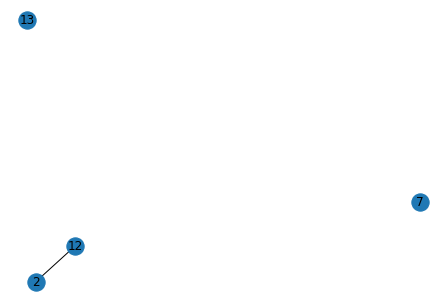

match_branches = [[2, 12]]
edges_to_delete (resolve crossover) = [[2, 7], [2, 13], [7, 12], [7, 13], [12, 13]]
edges_to_create (resolve crossover) = [[2, 12]]
curr_limb.deleted_edges 5 =[[2, 7], [2, 13], [7, 12], [7, 13], [12, 13], array([28, 34]), array([33, 34])]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[2, 7], [2, 13], [7, 12], [7, 13], [12, 13]]
edges_to_create = [[2, 12]]
Number of connected components = 4
Comp 0 = {0, 1, 2, 5, 6, 8, 9, 11, 12, 14, 15, 17, 18, 19, 20, 27, 28, 33, 36, 48, 49, 63, 67, 69, 70, 71, 72}
Comp 1 = {34, 3, 37}
Comp 2 = {7}
Comp 3 = {4, 10, 13, 16, 21, 22, 23, 24, 25, 26, 29, 30, 31, 32, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 68, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88}
curr_limb_copy.deleted_edges = [[2, 7], [2, 13], [7, 12], [7, 13], [12, 13], array([28, 34]), array([33, 34]), [2, 7], [2, 13], [7, 12], [7, 13], [12, 13]]
curr_limb_copy.created_edges =

  Edge: [58 56]: curr_angle = 8.46
  Edge: [56 51]: curr_angle = 8.71
  Edge: [51 50]: curr_angle = 64.87
  Edge: [50 54]: curr_angle = 111.71
  Edge: [54 57]: curr_angle = 20.6
  Edge: [57 60]: curr_angle = 24.37
  Edge: [60 64]: curr_angle = 5.14
  Edge: [64 13]: curr_angle = 105.64
  Edge: [13 66]: curr_angle = 66.0

Total time for doubling_back = 0.4656219482421875
There were 2 edges that passed doubling back threshold of 100
Winning edge [50 54] had a doubling back of 111.70872103189035
***inside resolve crossover!!!!****
coordinate_branches = [50, 53, 54]
50 = red
53 = aqua
54 = purple
Angle between 50 and 53 = 73.79 
Angle between 50 and 54 = 107.03 
Angle between 53 and 54 = 2.85 
Final Matches = [[53, 54]]
matched_branches_revised = [[53, 54]]
Original graph


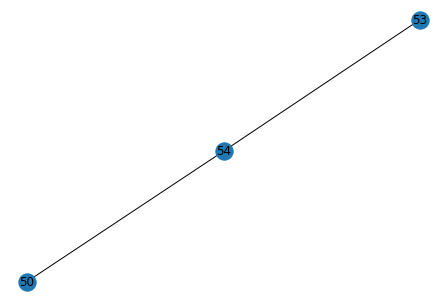

match_branches = [[53, 54]]
edges_to_delete (resolve crossover) = [[50, 53], [50, 54]]
edges_to_create (resolve crossover) = [[53, 54]]
edges_to_delete (cut_limb_network) = [array([50, 53]), array([50, 54])]
edges_to_create = [[53, 54]]
Number of connected components = 4
Comp 0 = {0, 1, 2, 5, 6, 8, 9, 11, 12, 14, 15, 17, 18, 19, 20, 27, 28, 33, 36, 48, 49, 63, 67, 69, 70, 71, 72}
Comp 1 = {34, 3, 37}
Comp 2 = {7}
Comp 3 = {4, 10, 13, 16, 21, 22, 23, 24, 25, 26, 29, 30, 31, 32, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 68, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88}
curr_limb_copy.deleted_edges = [[2, 7], [2, 13], [7, 12], [7, 13], [12, 13], array([28, 34]), array([33, 34]), [2, 7], [2, 13], [7, 12], [7, 13], [12, 13], array([50, 53]), array([50, 54])]
curr_limb_copy.created_edges = [[2, 12], [28, 33], [2, 12], [53, 54]]
After get best cut: cut_edges = [array([50, 53]), array([50, 54])], added_edges = 

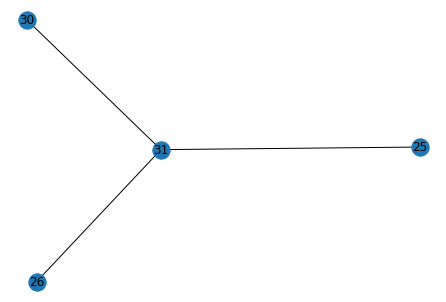

match_branches = [[26, 30], [25, 31]]
edges_to_delete (resolve crossover) = [[25, 26], [25, 30], [26, 31], [30, 31]]
edges_to_create (resolve crossover) = [[26, 30], [25, 31]]
curr_limb.deleted_edges 5 =[[2, 7], [2, 13], [7, 12], [7, 13], [12, 13], array([28, 34]), array([33, 34]), [2, 7], [2, 13], [7, 12], [7, 13], [12, 13], array([50, 53]), array([50, 54])]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[25, 26], [25, 30], [26, 31], [30, 31]]
edges_to_create = [[26, 30], [25, 31]]
Number of connected components = 6
Comp 0 = {0, 1, 2, 5, 6, 8, 9, 11, 12, 14, 15, 17, 18, 19, 20, 27, 28, 33, 36, 48, 49, 63, 67, 69, 70, 71, 72}
Comp 1 = {34, 3, 37}
Comp 2 = {7}
Comp 3 = {4, 10, 13, 24, 25, 31, 32, 35, 39, 41, 45, 52, 53, 54, 57, 60, 61, 62, 64, 65, 66, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88}
Comp 4 = {26, 68, 38, 40, 42, 43, 44, 46, 47, 16, 50, 51, 21, 22, 23, 56, 55, 58, 59, 30}
Comp 5 = {29}
curr_limb_copy.deleted_edges = [[2, 7], [2, 13], [7, 12], [7, 13

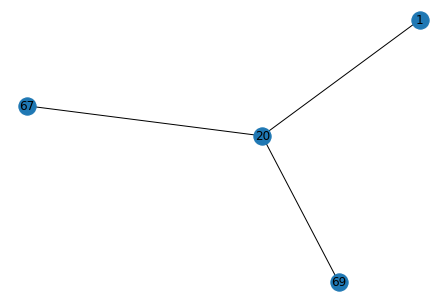

match_branches = [[20, 69]]
edges_to_delete (resolve crossover) = [[1, 20], [1, 67], [1, 69], [20, 67], [67, 69]]
edges_to_create (resolve crossover) = [[20, 69]]
curr_limb.deleted_edges 5 =[[2, 7], [2, 13], [7, 12], [7, 13], [12, 13], array([28, 34]), array([33, 34]), [2, 7], [2, 13], [7, 12], [7, 13], [12, 13], array([50, 53]), array([50, 54]), [25, 26], [25, 30], [26, 31], [30, 31]]
Skipping endnode 69 because skeletal distance was 950.9320359287357 and threshold was 2500
skip_nodes = [69]
edges_to_delete (cut_limb_network) = [[1, 20], [1, 67], [1, 69], [20, 67], [67, 69]]
edges_to_create = [[20, 69]]
Number of connected components = 8
Comp 0 = {33, 2, 5, 6, 69, 8, 11, 12, 14, 15, 17, 18, 19, 20, 27, 28, 63}
Comp 1 = {34, 3, 37}
Comp 2 = {7}
Comp 3 = {4, 10, 13, 24, 25, 31, 32, 35, 39, 41, 45, 52, 53, 54, 57, 60, 61, 62, 64, 65, 66, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88}
Comp 4 = {1}
Comp 5 = {0, 67, 36, 70, 71, 72, 9, 48, 49}
Comp 6 = {26, 68, 38, 40, 42, 4

  Edge: [63 33]: curr_angle = 43.94
  Edge: [33 28]: curr_angle = 15.22
  Edge: [28 27]: curr_angle = 75.46
  Edge: [27 18]: curr_angle = 81.06
  Edge: [18 19]: curr_angle = 104.2
  Edge: [19 20]: curr_angle = 56.5

Total time for doubling_back = 0.21389293670654297
There were 1 edges that passed doubling back threshold of 100
Winning edge [18 19] had a doubling back of 104.19575231640742
***inside resolve crossover!!!!****
coordinate_branches = [14, 18, 19]
14 = red
18 = aqua
19 = purple
Angle between 14 and 18 = 10.16 
Angle between 14 and 19 = 86.87 
Angle between 18 and 19 = 88.84 
Final Matches = [[14, 18]]
matched_branches_revised = [[14, 18]]
Original graph


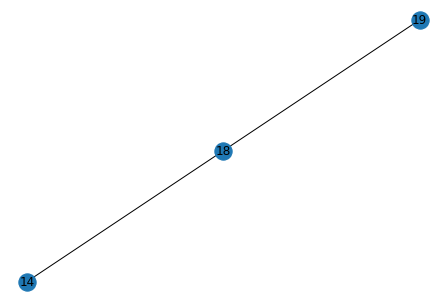

match_branches = [[14, 18]]
edges_to_delete (resolve crossover) = [[14, 19], [18, 19]]
edges_to_create (resolve crossover) = [[14, 18]]
edges_to_delete (cut_limb_network) = [array([14, 19]), array([18, 19])]
edges_to_create = [[14, 18]]
Number of connected components = 9
Comp 0 = {33, 2, 5, 6, 8, 11, 12, 14, 15, 18, 27, 28, 63}
Comp 1 = {34, 3, 37}
Comp 2 = {17, 19, 20, 69}
Comp 3 = {7}
Comp 4 = {4, 10, 13, 24, 25, 31, 32, 35, 39, 41, 45, 52, 53, 54, 57, 60, 61, 62, 64, 65, 66, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88}
Comp 5 = {1}
Comp 6 = {0, 67, 36, 70, 71, 72, 9, 48, 49}
Comp 7 = {26, 68, 38, 40, 42, 43, 44, 46, 47, 16, 50, 51, 21, 22, 23, 56, 55, 58, 59, 30}
Comp 8 = {29}
curr_limb_copy.deleted_edges = [[2, 7], [2, 13], [7, 12], [7, 13], [12, 13], array([28, 34]), array([33, 34]), [2, 7], [2, 13], [7, 12], [7, 13], [12, 13], array([50, 53]), array([50, 54]), [25, 26], [25, 30], [26, 31], [30, 31], [1, 20], [1, 67], [1, 69], [20, 67], [67, 69], array([14, 19])

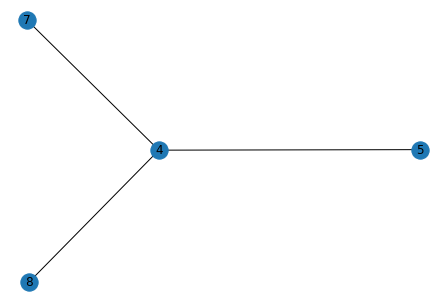

match_branches = [[5, 7], [4, 8]]
edges_to_delete (resolve crossover) = [[4, 5], [4, 7], [5, 8], [7, 8]]
edges_to_create (resolve crossover) = [[5, 7], [4, 8]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[4, 5], [4, 7], [5, 8], [7, 8]]
edges_to_create = [[5, 7], [4, 8]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 5, 6, 7, 9, 10, 15, 16, 17, 18}
Comp 1 = {4, 8, 11, 12, 13, 14}
curr_limb_copy.deleted_edges = [[4, 5], [4, 7], [5, 8], [7, 8]]
curr_limb_copy.created_edges = [[5, 7], [4, 8]]
After get best cut: cut_edges = [[4, 5], [4, 7], [5, 8], [7, 8]], added_edges = [[5, 7], [4, 8]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([ 0,  1,  2,  3,  5,  6,  7,  9

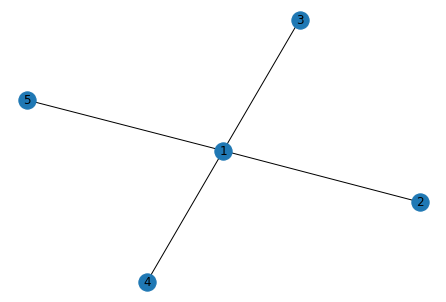

match_branches = [[1, 5]]
edges_to_delete (resolve crossover) = [[1, 2], [1, 3], [1, 4], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
edges_to_create (resolve crossover) = [[1, 5]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[1, 2], [1, 3], [1, 4], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
edges_to_create = [[1, 5]]
Number of connected components = 4
Comp 0 = {4}
Comp 1 = {0, 1, 5, 6}
Comp 2 = {2}
Comp 3 = {3}
curr_limb_copy.deleted_edges = [[1, 2], [1, 3], [1, 4], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]
curr_limb_copy.created_edges = [[1, 5]]
After get best cut: cut_edges = [[1, 2], [1, 3], [1, 4], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]], added_edges = [[1, 5]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 4
Total number of graphs at the end of the split AFTER DIRECTIONAL = 4
No valid path so moving onto the next connec

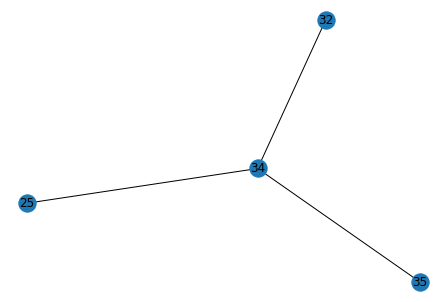

match_branches = []
edges_to_delete (resolve crossover) = [[25, 32], [25, 34], [25, 35], [32, 34], [32, 35], [34, 35]]
edges_to_create (resolve crossover) = []
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[25, 32], [25, 34], [25, 35], [32, 34], [32, 35], [34, 35]]
edges_to_create = []
Number of connected components = 8
Comp 0 = {34}
Comp 1 = {1, 2, 4, 7, 11, 21, 25}
Comp 2 = {0, 3, 5, 6, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 26, 27, 28, 29, 30, 31, 32, 37, 38, 39, 40, 41, 42, 43, 44, 47, 49, 51}
Comp 3 = {10, 23, 35, 36, 45, 46, 48, 50, 52, 53, 54, 55, 56, 57, 60, 61, 62, 63.0, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91}
Comp 4 = {33}
Comp 5 = {58}
Comp 6 = {59}
Comp 7 = {66}
curr_limb_copy.deleted_edges = [[25, 32], [25, 34], [25, 35], [32, 34], [32, 35], [34, 35]]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [[25, 32], [25, 34], [25, 35], [32, 34], [

  Edge: [71 74]: curr_angle = 71.0
  Edge: [74 78]: curr_angle = 82.77

Total time for doubling_back = 0.04921412467956543

Attempting the width jump check (attempting from both sides)
  Edge: [71 74]: jump = 143.11
  Edge: [74 78]: jump = 190.09
Total time for width = 0.02044963836669922
Path starting at 71 had err_edges: []


----- Working on 864691135440585800-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = [ 2 13]
multi_touch_limbs = [0 2]


 -------- Working on limb 0------------
Starting combinations to process = [[31 41]
 [31 43]
 [41 43]]


---- working on disconnecting 31 and 41
---- This disconnects S1_0 from S1_2  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 1
Total number of graphs at the end of the split AFTER DIRECTIONAL = 1
Shortest path = [31, 29, 30, 21, 22, 28, 35, 39, 44, 46, 51, 47, 41]

 --------- START OF GET BEST EDGE --------- 
curr_limb.deleted_edges=[]
consider_path_neighbors_for_remo

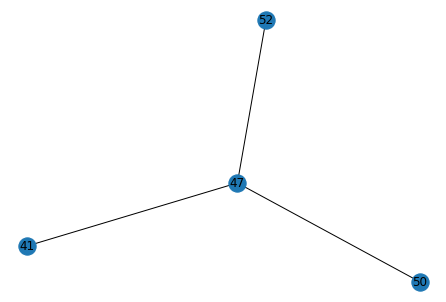

match_branches = [[41, 52]]
edges_to_delete (resolve crossover) = [[41, 47], [41, 50], [47, 50], [47, 52], [50, 52]]
edges_to_create (resolve crossover) = [[41, 52]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[41, 47], [41, 50], [47, 50], [47, 52], [50, 52]]
edges_to_create = [[41, 52]]
Number of connected components = 4
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 49, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61}
Comp 1 = {41, 52}
Comp 2 = {50}
Comp 3 = {48}
curr_limb_copy.deleted_edges = [[41, 47], [41, 50], [47, 50], [47, 52], [50, 52]]
curr_limb_copy.created_edges = [[41, 52]]
After get best cut: cut_edges = [[41, 47], [41, 50], [47, 50], [47, 52], [50, 52]], added_edges = [[41, 52]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the spl

  Edge: [31 29]: curr_angle = 26.46
  Edge: [29 30]: curr_angle = 19.13
  Edge: [30 21]: curr_angle = 28.87
  Edge: [21 22]: curr_angle = 127.61
  Edge: [22 28]: curr_angle = 101.37
  Edge: [28 35]: curr_angle = 20.51
  Edge: [35 39]: curr_angle = 18.64
  Edge: [39 42]: curr_angle = 24.8
  Edge: [42 43]: curr_angle = 24.49

Total time for doubling_back = 0.4871840476989746
There were 2 edges that passed doubling back threshold of 100
Winning edge [21 22] had a doubling back of 127.60711872105617
***inside resolve crossover!!!!****
coordinate_branches = [20, 21, 22]
20 = red
21 = aqua
22 = purple
Angle between 20 and 21 = 36.57 
Angle between 20 and 22 = 41.44 
Angle between 21 and 22 = 127.46 
Final Matches = []
matched_branches_revised = []
Original graph


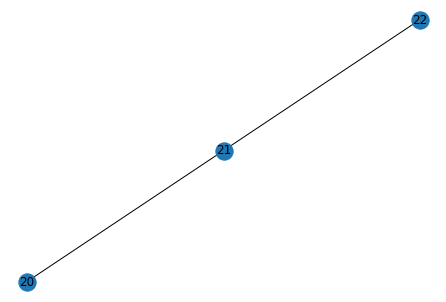

match_branches = []
edges_to_delete (resolve crossover) = [[20, 21], [20, 22], [21, 22]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([20, 21]), array([20, 22]), array([21, 22])]
edges_to_create = []
Number of connected components = 5
Comp 0 = {1, 4, 6, 10, 12, 13, 14, 21, 22, 24, 28, 29, 30, 31, 34, 35, 36, 37, 39, 40, 42, 43, 44, 45, 46, 47, 49, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61}
Comp 1 = {0, 2, 3, 5, 7, 8, 9, 11, 15, 16, 17, 18, 19, 20, 23, 25, 26, 27, 32, 33, 38}
Comp 2 = {41, 52}
Comp 3 = {50}
Comp 4 = {48}
curr_limb_copy.deleted_edges = [[41, 47], [41, 50], [47, 50], [47, 52], [50, 52], array([20, 21]), array([20, 22]), array([21, 22])]
curr_limb_copy.created_edges = [[41, 52]]
After get best cut: cut_edges = [array([20, 21]), array([20, 22]), array([21, 22])], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 5
Total num

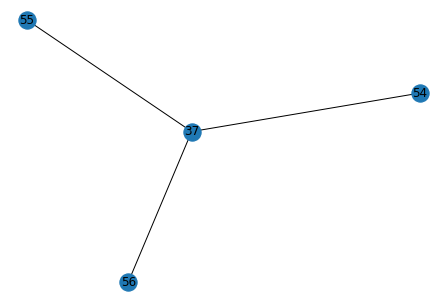

match_branches = [[37, 56]]
edges_to_delete (resolve crossover) = [[37, 54], [37, 55], [54, 55], [54, 56], [55, 56]]
edges_to_create (resolve crossover) = [[37, 56]]
curr_limb.deleted_edges 5 =[[41, 47], [41, 50], [47, 50], [47, 52], [50, 52], array([20, 21]), array([20, 22]), array([21, 22])]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[37, 54], [37, 55], [54, 55], [54, 56], [55, 56]]
edges_to_create = [[37, 56]]
Number of connected components = 7
Comp 0 = {1, 34, 4, 36, 6, 37, 10, 14, 21, 56, 29, 30, 31}
Comp 1 = {0, 2, 3, 5, 7, 8, 9, 11, 15, 16, 17, 18, 19, 20, 23, 25, 26, 27, 32, 33, 38}
Comp 2 = {12, 13, 22, 24, 28, 35, 39, 40, 42, 43, 44, 45, 46, 47, 49, 51, 53, 54, 57, 58, 59, 60, 61}
Comp 3 = {55}
Comp 4 = {41, 52}
Comp 5 = {50}
Comp 6 = {48}
curr_limb_copy.deleted_edges = [[41, 47], [41, 50], [47, 50], [47, 52], [50, 52], array([20, 21]), array([20, 22]), array([21, 22]), [37, 54], [37, 55], [54, 55], [54, 56], [55, 56]]
curr_limb_copy.created_edges = [[41, 52], [37,

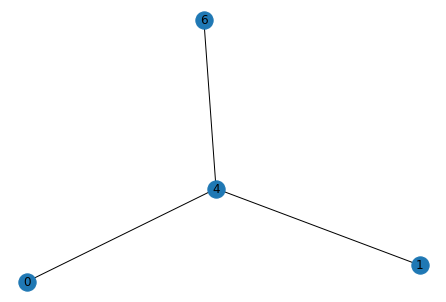

match_branches = [[0, 4], [1, 6]]
edges_to_delete (resolve crossover) = [[0, 1], [0, 6], [1, 4], [4, 6]]
edges_to_create (resolve crossover) = [[0, 4], [1, 6]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[0, 1], [0, 6], [1, 4], [4, 6]]
edges_to_create = [[0, 4], [1, 6]]
Number of connected components = 3
Comp 0 = {1, 3, 6, 8, 10, 15, 16, 18, 20, 21, 22, 23}
Comp 1 = {0, 2, 4, 7, 9, 11, 12, 13, 14, 17, 19, 24}
Comp 2 = {5}
curr_limb_copy.deleted_edges = [[0, 1], [0, 6], [1, 4], [4, 6]]
curr_limb_copy.created_edges = [[0, 4], [1, 6]]
After get best cut: cut_edges = [[0, 1], [0, 6], [1, 4], [4, 6]], added_edges = [[0, 4], [1, 6]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection


---- working on disconnecting 19 and 24
---- This disc

  Edge: [19 13]: curr_angle = 19.86
  Edge: [13 12]: curr_angle = 159.26
  Edge: [12 24]: curr_angle = 45.03

Total time for doubling_back = 0.2612791061401367
There were 1 edges that passed doubling back threshold of 100
Winning edge [13 12] had a doubling back of 159.25676226652962
***inside resolve crossover!!!!****
coordinate_branches = [9, 12, 13]
9 = red
12 = aqua
13 = purple
Angle between 9 and 12 = 91.94 
Angle between 9 and 13 = 9.92 
Angle between 12 and 13 = 92.11 
Final Matches = [[9, 13]]
matched_branches_revised = [[9, 13]]
Original graph


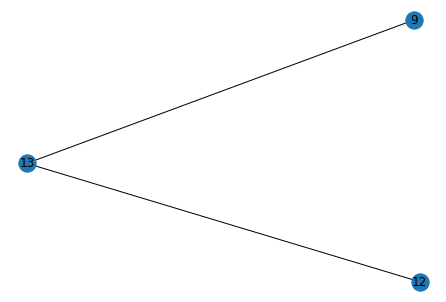

match_branches = [[9, 13]]
edges_to_delete (resolve crossover) = [[9, 12], [12, 13]]
edges_to_create (resolve crossover) = [[9, 13]]
edges_to_delete (cut_limb_network) = [array([ 9, 12]), array([12, 13])]
edges_to_create = [[9, 13]]
Number of connected components = 4
Comp 0 = {1, 3, 6, 8, 10, 15, 16, 18, 20, 21, 22, 23}
Comp 1 = {0, 2, 4, 7, 9, 13, 19}
Comp 2 = {11, 12, 14, 17, 24}
Comp 3 = {5}
curr_limb_copy.deleted_edges = [[0, 1], [0, 6], [1, 4], [4, 6], array([ 9, 12]), array([12, 13])]
curr_limb_copy.created_edges = [[0, 4], [1, 6], [9, 13]]
After get best cut: cut_edges = [array([ 9, 12]), array([12, 13])], added_edges = [[9, 13]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 4
Total number of graphs at the end of the split AFTER DIRECTIONAL = 4
No valid path so moving onto the next connection


---- working on disconnecting 23 and 24
---- This disconnects S1_0 from S0_0  
 Cut 

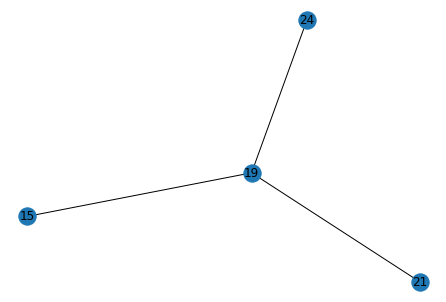

match_branches = [[15, 19], [21, 24]]
edges_to_delete (resolve crossover) = [[15, 21], [15, 24], [19, 21], [19, 24]]
edges_to_create (resolve crossover) = [[15, 19], [21, 24]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[15, 21], [15, 24], [19, 21], [19, 24]]
edges_to_create = [[15, 19], [21, 24]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52}
Comp 1 = {53}
curr_limb_copy.deleted_edges = [[15, 21], [15, 24], [19, 21], [19, 24]]
curr_limb_copy.created_edges = [[15, 19], [21, 24]]
After get best cut: cut_edges = [[15, 21], [15, 24], [19, 21], [19, 24]], added_edges = [[15, 19], [21, 24]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of 

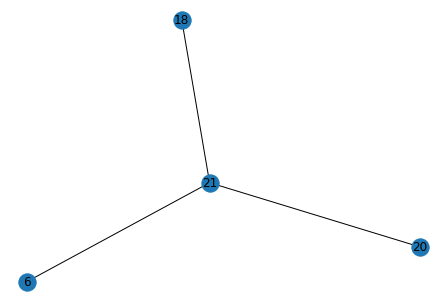

match_branches = [[6, 18]]
edges_to_delete (resolve crossover) = [[6, 20], [6, 21], [18, 20], [18, 21], [20, 21]]
edges_to_create (resolve crossover) = [[6, 18]]
curr_limb.deleted_edges 5 =[[15, 21], [15, 24], [19, 21], [19, 24]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[6, 20], [6, 21], [18, 20], [18, 21], [20, 21]]
edges_to_create = [[6, 18]]
Number of connected components = 5
Comp 0 = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 23, 27, 30, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50}
Comp 1 = {20}
Comp 2 = {32, 0, 13, 51, 52, 21, 24, 25, 26, 28, 29, 31}
Comp 3 = {22}
Comp 4 = {53}
curr_limb_copy.deleted_edges = [[15, 21], [15, 24], [19, 21], [19, 24], [6, 20], [6, 21], [18, 20], [18, 21], [20, 21]]
curr_limb_copy.created_edges = [[15, 19], [21, 24], [6, 18]]
After get best cut: cut_edges = [[6, 20], [6, 21], [18, 20], [18, 21], [20, 21]], added_edges = [[6, 18]]
total_soma_paths_to_cut = [[15, 21], [15, 24], [19, 21], [19, 

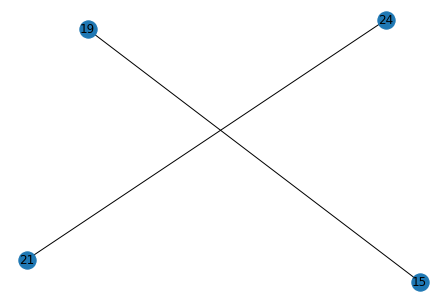

match_branches = [[15, 19], [21, 24]]
edges_to_delete (resolve crossover) = [[15, 21], [15, 24], [19, 21], [19, 24]]
edges_to_create (resolve crossover) = [[15, 19], [21, 24]]
curr_limb.deleted_edges 5 =[[15, 21], [15, 24], [19, 21], [19, 24], [6, 20], [6, 21], [18, 20], [18, 21], [20, 21]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[15, 21], [15, 24], [19, 21], [19, 24]]
edges_to_create = [[15, 19], [21, 24]]
Number of connected components = 5
Comp 0 = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 23, 27, 30, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50}
Comp 1 = {20}
Comp 2 = {32, 0, 13, 51, 52, 21, 24, 25, 26, 28, 29, 31}
Comp 3 = {22}
Comp 4 = {53}
curr_limb_copy.deleted_edges = [[15, 21], [15, 24], [19, 21], [19, 24], [6, 20], [6, 21], [18, 20], [18, 21], [20, 21], [15, 21], [15, 24], [19, 21], [19, 24]]
curr_limb_copy.created_edges = [[15, 19], [21, 24], [6, 18], [15, 19], [21, 24]]
After get best cut: cut_edges = [[15, 21], 

  Edge: [8 9]: curr_angle = 33.91
  Edge: [ 9 12]: curr_angle = 3.48
  Edge: [12 19]: curr_angle = 80.53
  Edge: [19 15]: curr_angle = 3.28
  Edge: [15 16]: curr_angle = 42.81
  Edge: [16 23]: curr_angle = 118.31
  Edge: [23 44]: curr_angle = 37.61
  Edge: [44 37]: curr_angle = 42.54
  Edge: [37 38]: curr_angle = 21.88
  Edge: [38 39]: curr_angle = 106.66
  Edge: [39 47]: curr_angle = 23.3
  Edge: [47 49]: curr_angle = 146.84
  Edge: [49 43]: curr_angle = 144.41
  Edge: [43 35]: curr_angle = 26.48
  Edge: [35 30]: curr_angle = 31.19

Total time for doubling_back = 0.5882256031036377
There were 4 edges that passed doubling back threshold of 100
Winning edge [47 49] had a doubling back of 146.83825366620084
***inside resolve crossover!!!!****
coordinate_branches = [47, 48, 49]
47 = red
48 = aqua
49 = purple
Angle between 47 and 48 = 24.52 
Angle between 47 and 49 = 140.19 
Angle between 48 and 49 = 34.34 
Final Matches = [[47, 48], [48, 49]]
matched_branches_revised = [[47, 48]]
Original

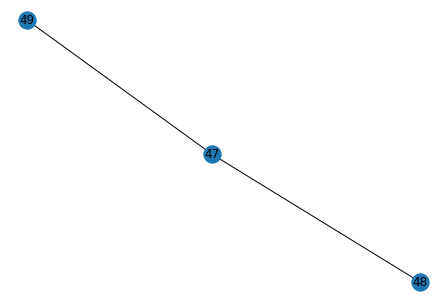

match_branches = [[47, 48]]
edges_to_delete (resolve crossover) = [[47, 49], [48, 49]]
edges_to_create (resolve crossover) = [[47, 48]]
edges_to_delete (cut_limb_network) = [array([47, 49]), array([48, 49])]
edges_to_create = [[47, 48]]
Number of connected components = 6
Comp 0 = {1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 17, 18, 19, 23, 33, 34, 37, 38, 39, 41, 44, 46, 47, 48}
Comp 1 = {35, 36, 40, 42, 43, 10, 45, 49, 50, 27, 30}
Comp 2 = {20}
Comp 3 = {32, 0, 13, 51, 52, 21, 24, 25, 26, 28, 29, 31}
Comp 4 = {22}
Comp 5 = {53}
curr_limb_copy.deleted_edges = [[15, 21], [15, 24], [19, 21], [19, 24], [6, 20], [6, 21], [18, 20], [18, 21], [20, 21], [15, 21], [15, 24], [19, 21], [19, 24], array([47, 49]), array([48, 49])]
curr_limb_copy.created_edges = [[15, 19], [21, 24], [6, 18], [15, 19], [21, 24], [47, 48]]
After get best cut: cut_edges = [array([47, 49]), array([48, 49])], added_edges = [[47, 48]]
total_soma_paths_to_cut = [[15, 21], [15, 24], [19, 21], [19, 24]]
-----------counte

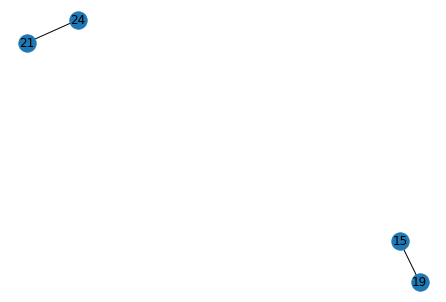

match_branches = [[15, 19], [21, 24]]
edges_to_delete (resolve crossover) = [[15, 21], [15, 24], [19, 21], [19, 24]]
edges_to_create (resolve crossover) = [[15, 19], [21, 24]]
curr_limb.deleted_edges 5 =[[15, 21], [15, 24], [19, 21], [19, 24], [6, 20], [6, 21], [18, 20], [18, 21], [20, 21], [15, 21], [15, 24], [19, 21], [19, 24], array([47, 49]), array([48, 49])]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[15, 21], [15, 24], [19, 21], [19, 24]]
edges_to_create = [[15, 19], [21, 24]]
Number of connected components = 6
Comp 0 = {1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 17, 18, 19, 23, 33, 34, 37, 38, 39, 41, 44, 46, 47, 48}
Comp 1 = {35, 36, 40, 42, 43, 10, 45, 49, 50, 27, 30}
Comp 2 = {20}
Comp 3 = {32, 0, 13, 51, 52, 21, 24, 25, 26, 28, 29, 31}
Comp 4 = {22}
Comp 5 = {53}
curr_limb_copy.deleted_edges = [[15, 21], [15, 24], [19, 21], [19, 24], [6, 20], [6, 21], [18, 20], [18, 21], [20, 21], [15, 21], [15, 24], [19, 21], [19, 24], array([47, 49]), array([48, 49]), [15, 2

  Edge: [8 9]: curr_angle = 33.91
  Edge: [ 9 12]: curr_angle = 3.48
  Edge: [12 19]: curr_angle = 80.53
  Edge: [19 15]: curr_angle = 3.28
  Edge: [15 16]: curr_angle = 42.81
  Edge: [16 23]: curr_angle = 118.31
  Edge: [23 44]: curr_angle = 37.61
  Edge: [44 37]: curr_angle = 42.54
  Edge: [37 38]: curr_angle = 21.88
  Edge: [38 34]: curr_angle = 30.3

Total time for doubling_back = 0.40436244010925293
There were 1 edges that passed doubling back threshold of 100
Winning edge [16 23] had a doubling back of 118.3148129079221
***inside resolve crossover!!!!****
coordinate_branches = [16, 18, 23]
16 = red
18 = aqua
23 = purple
Angle between 16 and 18 = 106.73 
Angle between 16 and 23 = 87.92 
Angle between 18 and 23 = 15.98 
Final Matches = [[18, 23]]
matched_branches_revised = [[18, 23]]
Original graph


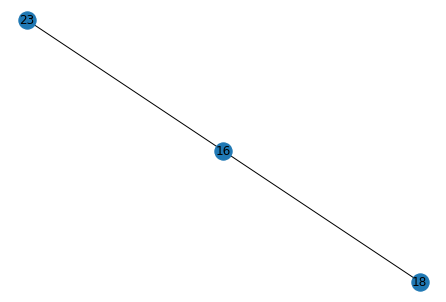

match_branches = [[18, 23]]
edges_to_delete (resolve crossover) = [[16, 18], [16, 23]]
edges_to_create (resolve crossover) = [[18, 23]]
edges_to_delete (cut_limb_network) = [array([16, 18]), array([16, 23])]
edges_to_create = [[18, 23]]
Number of connected components = 7
Comp 0 = {33, 34, 3, 37, 38, 39, 6, 41, 44, 46, 47, 48, 18, 23}
Comp 1 = {35, 36, 40, 42, 43, 10, 45, 49, 50, 27, 30}
Comp 2 = {1, 2, 4, 5, 7, 8, 9, 11, 12, 14, 15, 16, 17, 19}
Comp 3 = {20}
Comp 4 = {32, 0, 13, 51, 52, 21, 24, 25, 26, 28, 29, 31}
Comp 5 = {22}
Comp 6 = {53}
curr_limb_copy.deleted_edges = [[15, 21], [15, 24], [19, 21], [19, 24], [6, 20], [6, 21], [18, 20], [18, 21], [20, 21], [15, 21], [15, 24], [19, 21], [19, 24], array([47, 49]), array([48, 49]), [15, 21], [15, 24], [19, 21], [19, 24], array([16, 18]), array([16, 23])]
curr_limb_copy.created_edges = [[15, 19], [21, 24], [6, 18], [15, 19], [21, 24], [47, 48], [15, 19], [21, 24], [18, 23]]
After get best cut: cut_edges = [array([16, 18]), array([16, 23

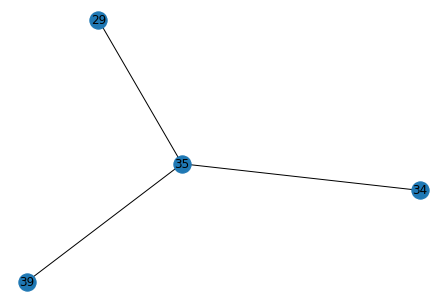

match_branches = [[29, 34]]
edges_to_delete (resolve crossover) = [[29, 35], [29, 39], [34, 35], [34, 39], [35, 39]]
edges_to_create (resolve crossover) = [[29, 34]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[29, 35], [29, 39], [34, 35], [34, 39], [35, 39]]
edges_to_create = [[29, 34]]
Number of connected components = 3
Comp 0 = {0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 15, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128}
Comp 1 = {35, 36, 6, 10, 44, 16, 17, 18, 19, 20, 23, 24, 60}
Comp 2 = {39}
curr_limb_copy.deleted_edges = [[29, 35], [29, 39], [34, 35], [34, 39],

  Edge: [21 22]: curr_angle = 19.4
  Edge: [22 26]: curr_angle = 16.86
  Edge: [26 37]: curr_angle = 18.19
  Edge: [37 41]: curr_angle = 17.98
  Edge: [41 49]: curr_angle = 25.76
  Edge: [49 45]: curr_angle = 143.7
  Edge: [45 28]: curr_angle = 60.37

Total time for doubling_back = 0.22669053077697754
There were 1 edges that passed doubling back threshold of 100
Winning edge [49 45] had a doubling back of 143.70234990589563
***inside resolve crossover!!!!****
coordinate_branches = [45, 48, 49]
45 = red
48 = aqua
49 = purple
Angle between 45 and 48 = 20.34 
Angle between 45 and 49 = 151.64 
Angle between 48 and 49 = 20.96 
Final Matches = [[45, 48], [48, 49]]
matched_branches_revised = [[45, 48]]
Original graph


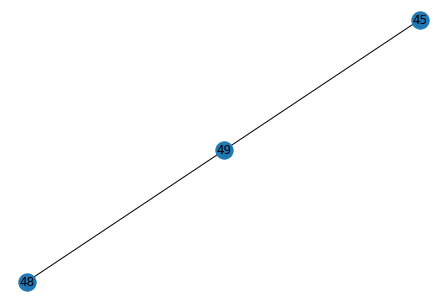

match_branches = [[45, 48]]
edges_to_delete (resolve crossover) = [[45, 49], [48, 49]]
edges_to_create (resolve crossover) = [[45, 48]]
edges_to_delete (cut_limb_network) = [array([45, 49]), array([48, 49])]
edges_to_create = [[45, 48]]
Number of connected components = 3
Comp 0 = {0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 15, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128}
Comp 1 = {35, 36, 6, 10, 44, 16, 17, 18, 19, 20, 23, 24, 60}
Comp 2 = {39}
curr_limb_copy.deleted_edges = [[29, 35], [29, 39], [34, 35], [34, 39], [35, 39], array([45, 49]), array([48, 49])]
curr_limb_copy.created_edges = [[29, 34], [45, 

  Edge: [21 22]: curr_angle = 19.4
  Edge: [22 25]: curr_angle = 58.75
  Edge: [25 38]: curr_angle = 57.05
  Edge: [38 78]: curr_angle = 22.32
  Edge: [78 81]: curr_angle = 73.96
  Edge: [ 81 104]: curr_angle = 109.78
  Edge: [104 102]: curr_angle = 38.86
  Edge: [102 110]: curr_angle = 22.33
  Edge: [110  94]: curr_angle = 24.84
  Edge: [94 71]: curr_angle = 60.85
  Edge: [71 50]: curr_angle = 26.84
  Edge: [50 48]: curr_angle = 58.74
  Edge: [48 45]: curr_angle = 29.42
  Edge: [45 28]: curr_angle = 60.37

Total time for doubling_back = 1.183624505996704
There were 1 edges that passed doubling back threshold of 100
Winning edge [ 81 104] had a doubling back of 109.77812821099509
***inside resolve crossover!!!!****
coordinate_branches = [81, 104, 106]
81 = red
104 = aqua
106 = purple
Angle between 81 and 104 = 106.91 
Angle between 81 and 106 = 54.86 
Angle between 104 and 106 = 115.67 
Final Matches = []
matched_branches_revised = []
Original graph


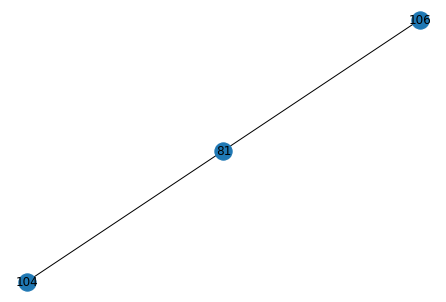

match_branches = []
edges_to_delete (resolve crossover) = [[81, 104], [81, 106], [104, 106]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([ 81, 104]), array([ 81, 106]), array([104, 106])]
edges_to_create = []
Number of connected components = 5
Comp 0 = {128, 1, 0, 3, 4, 5, 2, 7, 8, 9, 11, 13, 14, 15, 21, 22, 25, 26, 29, 30, 31, 33, 34, 37, 38, 40, 41, 42, 43, 49, 57, 74, 75, 76, 77, 78, 81, 91, 92, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
Comp 1 = {35, 36, 6, 10, 44, 16, 17, 18, 19, 20, 23, 24, 60}
Comp 2 = {39}
Comp 3 = {12, 27, 28, 32, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112}
Comp 4 = {106}
curr_limb_copy.deleted_edges = [[29, 35], [29, 39], [34, 35], [34, 39], [35, 39], array([45, 49]), array([48, 49]), array([ 81, 10

  Edge: [7 6]: curr_angle = 15.84
  Edge: [6 5]: curr_angle = 157.58
  Edge: [5 9]: curr_angle = 107.96
  Edge: [9 8]: curr_angle = 48.57
  Edge: [ 8 12]: curr_angle = 55.77
  Edge: [12 14]: curr_angle = 37.78
  Edge: [14 13]: curr_angle = 42.72

Total time for doubling_back = 0.20364046096801758
There were 2 edges that passed doubling back threshold of 100
Winning edge [6 5] had a doubling back of 157.57816665568924
***inside resolve crossover!!!!****
coordinate_branches = [2, 5, 6]
2 = red
5 = aqua
6 = purple
Angle between 2 and 5 = 131.72 
Angle between 2 and 6 = 41.25 
Angle between 5 and 6 = 7.91 
Final Matches = [[5, 6]]
matched_branches_revised = [[5, 6]]
Original graph


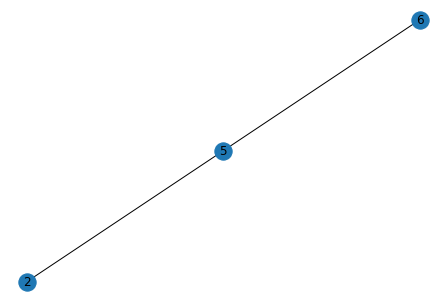

match_branches = [[5, 6]]
edges_to_delete (resolve crossover) = [[2, 5], [2, 6]]
edges_to_create (resolve crossover) = [[5, 6]]
Rejecting creating edge [5, 6] becuase did not involve only 1 node in the deleted edge
edges_to_delete (cut_limb_network) = [array([2, 5]), array([2, 6]), array([5, 6])]
edges_to_create = []
Number of connected components = 3
Comp 0 = {3, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}
Comp 1 = {2}
Comp 2 = {0, 1, 4, 6, 7}
curr_limb_copy.deleted_edges = [array([2, 5]), array([2, 6]), array([5, 6])]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [array([2, 5]), array([2, 6]), array([5, 6])], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 3: [array

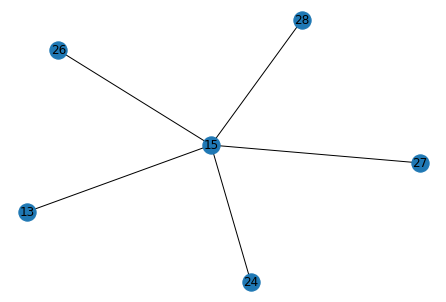

match_branches = [[13, 28], [24, 26], [15, 27]]
edges_to_delete (resolve crossover) = [[13, 15], [13, 24], [13, 26], [13, 27], [15, 24], [15, 26], [15, 28], [24, 27], [24, 28], [26, 27], [26, 28], [27, 28]]
edges_to_create (resolve crossover) = [[13, 28], [24, 26], [15, 27]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 49 because skeletal distance was 722.4215952840823 and threshold was 2500
skip_nodes = [49]
edges_to_delete (cut_limb_network) = [[13, 15], [13, 24], [13, 26], [13, 27], [15, 24], [15, 26], [15, 28], [24, 27], [24, 28], [26, 27], [26, 28], [27, 28]]
edges_to_create = [[13, 28], [24, 26], [15, 27]]
Number of connected components = 4
Comp 0 = {0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64}
Comp 1 = {28, 13}
Comp 2 = {24, 26, 4, 14}
Comp 3 = {25}
curr_limb_copy.deleted_edges = [[13, 15], [13, 24], [

  Edge: [19 20]: curr_angle = 24.72
  Edge: [20 16]: curr_angle = 27.22
  Edge: [16 15]: curr_angle = 63.69
  Edge: [15 27]: curr_angle = 13.46
  Edge: [27 32]: curr_angle = 39.44
  Edge: [32 33]: curr_angle = 38.96
  Edge: [33 38]: curr_angle = 21.44
  Edge: [38 44]: curr_angle = 8.08
  Edge: [44 46]: curr_angle = 26.48
  Edge: [46 45]: curr_angle = 27.24

Total time for doubling_back = 0.9648587703704834

Attempting the width jump check (attempting from both sides)
  Edge: [19 20]: jump = -17.13
  Edge: [20 16]: jump = -53.29
  Edge: [16 15]: jump = -55.34
  Edge: [15 27]: jump = -193.6
  Edge: [27 32]: jump = 128.7
  Edge: [32 33]: jump = 345.19
Adding error edge [32 33] because width jump was 345.18554406115226
  Edge: [33 38]: jump = -5.14
  Edge: [38 44]: jump = 65.94
  Edge: [44 46]: jump = 62.15
  Edge: [46 45]: jump = 108.85
Total time for width = 0.9258322715759277
Path starting at 19 had err_edges: [[32, 33]]
  Edge: [45 46]: jump = -108.85
  Edge: [46 44]: jump = -62.15
  E

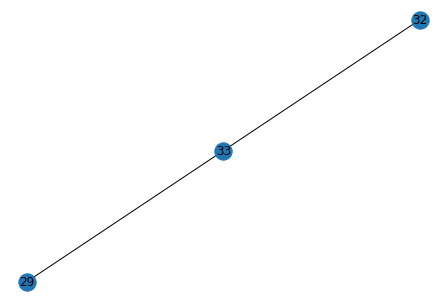

match_branches = [[29, 33]]
edges_to_delete (resolve crossover) = [[29, 32], [32, 33]]
edges_to_create (resolve crossover) = [[29, 33]]
edges_to_delete (cut_limb_network) = [array([29, 32]), array([32, 33])]
edges_to_create = [[29, 33]]
Number of connected components = 5
Comp 0 = {0, 2, 5, 7, 8, 9, 15, 16, 19, 20, 21, 27, 32, 34, 35, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64}
Comp 1 = {28, 13}
Comp 2 = {24, 26, 4, 14}
Comp 3 = {1, 3, 6, 10, 11, 12, 17, 18, 22, 23, 29, 30, 31, 33, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53}
Comp 4 = {25}
curr_limb_copy.deleted_edges = [[13, 15], [13, 24], [13, 26], [13, 27], [15, 24], [15, 26], [15, 28], [24, 27], [24, 28], [26, 27], [26, 28], [27, 28], array([29, 32]), array([32, 33])]
curr_limb_copy.created_edges = [[13, 28], [24, 26], [15, 27], [29, 33]]
After get best cut: cut_edges = [array([29, 32]), array([32, 33])], added_edges = [[29, 33]]
total_soma_paths_to_cut = [[13, 15], [13, 24], [13, 26], [13, 27], [15, 24], 

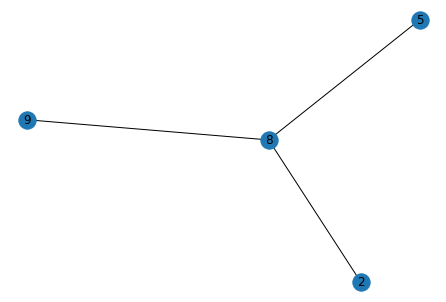

match_branches = [[2, 8], [5, 9]]
edges_to_delete (resolve crossover) = [[2, 5], [2, 9], [5, 8], [8, 9]]
edges_to_create (resolve crossover) = [[2, 8], [5, 9]]
curr_limb.deleted_edges 5 =[[13, 15], [13, 24], [13, 26], [13, 27], [15, 24], [15, 26], [15, 28], [24, 27], [24, 28], [26, 27], [26, 28], [27, 28], array([29, 32]), array([32, 33])]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[2, 5], [2, 9], [5, 8], [8, 9]]
edges_to_create = [[2, 8], [5, 9]]
Number of connected components = 7
Comp 0 = {64, 35, 5, 9, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63}
Comp 1 = {32, 0, 2, 34, 8, 15, 16, 19, 20, 21, 27}
Comp 2 = {28, 13}
Comp 3 = {24, 26, 4, 14}
Comp 4 = {1, 3, 6, 10, 11, 12, 17, 18, 22, 23, 29, 30, 31, 33, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53}
Comp 5 = {7}
Comp 6 = {25}
curr_limb_copy.deleted_edges = [[13, 15], [13, 24], [13, 26], [13, 27], [15, 24], [15, 26], [15, 28], [24, 27], [24, 28], [26, 27], [26, 28], [27, 28], array([29, 32]), array([32, 33

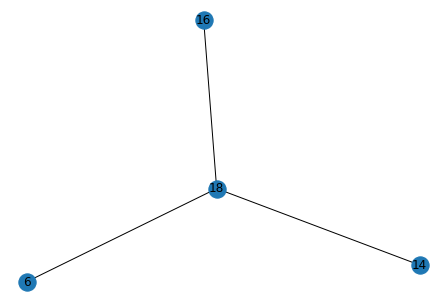

match_branches = []
edges_to_delete (resolve crossover) = [[6, 14], [6, 16], [6, 18], [14, 16], [14, 18], [16, 18]]
edges_to_create (resolve crossover) = []
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[6, 14], [6, 16], [6, 18], [14, 16], [14, 18], [16, 18]]
edges_to_create = []
Number of connected components = 5
Comp 0 = {18}
Comp 1 = {6}
Comp 2 = {0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42}
Comp 3 = {16}
Comp 4 = {17}
curr_limb_copy.deleted_edges = [[6, 14], [6, 16], [6, 18], [14, 16], [14, 18], [16, 18]]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [[6, 14], [6, 16], [6, 18], [14, 16], [14, 18], [16, 18]], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 5
Total number of graphs at the end of the split AFTER

  Edge: [33 29]: curr_angle = 32.85
  Edge: [29 27]: curr_angle = 6.12
  Edge: [27 25]: curr_angle = 20.39
  Edge: [25 14]: curr_angle = 55.66
  Edge: [14 17]: curr_angle = 40.81
  Edge: [17 15]: curr_angle = 103.34
  Edge: [15 21]: curr_angle = 51.94
  Edge: [21 31]: curr_angle = 23.63
  Edge: [31 35]: curr_angle = 5.76
  Edge: [35 43]: curr_angle = 42.76
  Edge: [43 42]: curr_angle = 24.4
  Edge: [42 45]: curr_angle = 19.33
  Edge: [45 48]: curr_angle = 30.19

Total time for doubling_back = 0.839569091796875
There were 1 edges that passed doubling back threshold of 100
Winning edge [17 15] had a doubling back of 103.34033110370643
***inside resolve crossover!!!!****
coordinate_branches = [15, 16, 17]
15 = red
16 = aqua
17 = purple
Angle between 15 and 16 = 141.47 
Angle between 15 and 17 = 131.98 
Angle between 16 and 17 = 119.22 
Final Matches = []
matched_branches_revised = []
Original graph


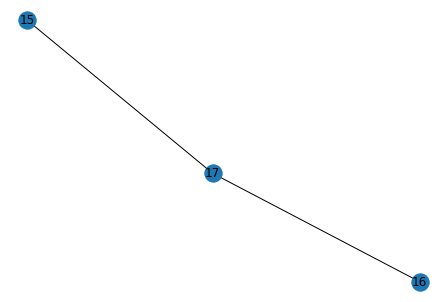

match_branches = []
edges_to_delete (resolve crossover) = [[15, 16], [15, 17], [16, 17]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([15, 16]), array([15, 17]), array([16, 17])]
edges_to_create = []
Number of connected components = 3
Comp 0 = {0, 1, 2, 3, 4, 6, 7, 10, 11, 12, 13, 15, 19, 21, 31, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64}
Comp 1 = {16}
Comp 2 = {5, 8, 9, 14, 17, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 46, 49}
curr_limb_copy.deleted_edges = [array([15, 16]), array([15, 17]), array([16, 17])]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [array([15, 16]), array([15, 17]), array([16, 17])], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No val

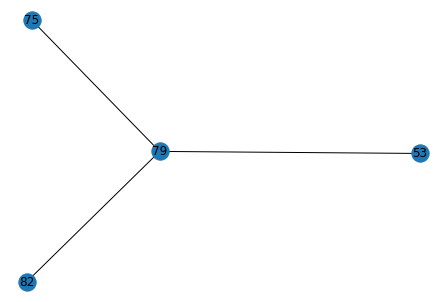

match_branches = [[75, 82]]
edges_to_delete (resolve crossover) = [[53, 75], [53, 79], [53, 82], [75, 79], [79, 82]]
edges_to_create (resolve crossover) = [[75, 82]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 84 because skeletal distance was 394.16559041583207 and threshold was 2500
skip_nodes = [84]
edges_to_delete (cut_limb_network) = [[53, 75], [53, 79], [53, 82], [75, 79], [79, 82]]
edges_to_create = [[75, 82]]
Number of connected components = 3
Comp 0 = {96, 64, 66, 98, 97, 102, 103, 70, 104, 74, 75, 105, 45, 82, 50, 84, 85, 88}
Comp 1 = {34, 36, 40, 53, 29}
Comp 2 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 35, 37, 38, 39, 41, 42, 43, 44, 46, 47, 48, 49, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 67, 68, 69, 71, 72, 73, 76, 77, 78, 79, 80, 81, 83, 86, 87, 89, 90, 91, 92, 93, 94, 95, 99, 100, 101}
curr_limb_copy.deleted_edges = [[53, 75], [53, 79], [53, 82], [75, 79], [79, 82]]
curr_limb_

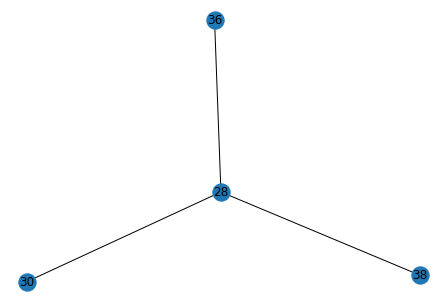

match_branches = [[30, 36], [28, 38]]
edges_to_delete (resolve crossover) = [[28, 30], [28, 36], [30, 38], [36, 38]]
edges_to_create (resolve crossover) = [[30, 36], [28, 38]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 43 because skeletal distance was 2142.7648676508256 and threshold was 2500
skip_nodes = [43]
edges_to_delete (cut_limb_network) = [[28, 30], [28, 36], [30, 38], [36, 38]]
edges_to_create = [[30, 36], [28, 38]]
Number of connected components = 6
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 37, 38, 39, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129}
Comp 1 = {36, 72, 10, 44, 

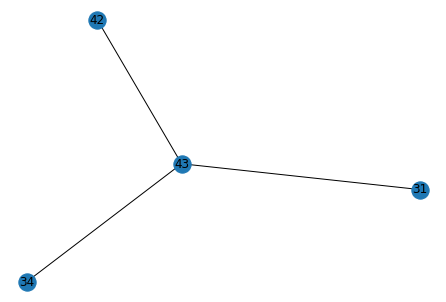

match_branches = [[34, 43]]
edges_to_delete (resolve crossover) = [[31, 34], [31, 42], [31, 43], [34, 42], [42, 43]]
edges_to_create (resolve crossover) = [[34, 43]]
curr_limb.deleted_edges 5 =[[28, 30], [28, 36], [30, 38], [36, 38]]
Skipping endnode 43 because skeletal distance was 2142.7648676508256 and threshold was 2500
skip_nodes = [43]
edges_to_delete (cut_limb_network) = [[31, 34], [31, 42], [31, 43], [34, 42], [42, 43]]
edges_to_create = [[34, 43]]
Number of connected components = 8
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 23, 26, 27, 28, 32, 33, 37, 38, 39, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129}
Comp 1 = {15, 21, 24, 25, 31}
Com

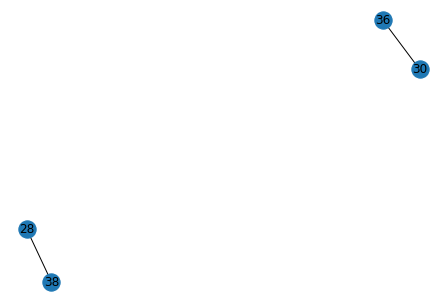

match_branches = [[30, 36], [28, 38]]
edges_to_delete (resolve crossover) = [[28, 30], [28, 36], [30, 38], [36, 38]]
edges_to_create (resolve crossover) = [[30, 36], [28, 38]]
curr_limb.deleted_edges 5 =[[28, 30], [28, 36], [30, 38], [36, 38], [31, 34], [31, 42], [31, 43], [34, 42], [42, 43]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[28, 30], [28, 36], [30, 38], [36, 38]]
edges_to_create = [[30, 36], [28, 38]]
Number of connected components = 8
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 23, 26, 27, 28, 32, 33, 37, 38, 39, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129}
Comp 1 = {15, 21, 24, 25, 31}
Comp 2 = {34, 43, 22, 7}
Comp 3 = {36

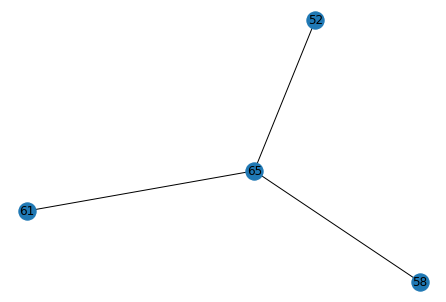

match_branches = [[52, 58]]
edges_to_delete (resolve crossover) = [[52, 61], [52, 65], [58, 61], [58, 65], [61, 65]]
edges_to_create (resolve crossover) = [[52, 58]]
curr_limb.deleted_edges 5 =[[28, 30], [28, 36], [30, 38], [36, 38], [31, 34], [31, 42], [31, 43], [34, 42], [42, 43], [28, 30], [28, 36], [30, 38], [36, 38]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[52, 61], [52, 65], [58, 61], [58, 65], [61, 65]]
edges_to_create = [[52, 58]]
Number of connected components = 10
Comp 0 = {0, 1, 2, 4, 6, 9, 11, 12, 13, 16, 17, 28, 37, 38, 42, 45, 46, 47, 52, 53, 58, 63, 64, 97, 115, 120, 121}
Comp 1 = {15, 21, 24, 25, 31}
Comp 2 = {34, 43, 22, 7}
Comp 3 = {36, 72, 10, 44, 56, 29, 30}
Comp 4 = {32, 3, 5, 41, 14, 48, 49, 59, 61, 62}
Comp 5 = {128, 129, 8, 18, 19, 20, 23, 26, 27, 33, 39, 50, 51, 54, 55, 57, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109

  Edge: [6 7]: curr_angle = 9.68
  Edge: [ 7 13]: curr_angle = 108.75
  Edge: [13 14]: curr_angle = 38.98
  Edge: [14 22]: curr_angle = 29.55
  Edge: [22 17]: curr_angle = 51.53
  Edge: [17 15]: curr_angle = 39.8

Total time for doubling_back = 0.3582174777984619
There were 1 edges that passed doubling back threshold of 100
Winning edge [ 7 13] had a doubling back of 108.75239495751067
***inside resolve crossover!!!!****
coordinate_branches = [7, 12, 13]
7 = red
12 = aqua
13 = purple
Angle between 7 and 12 = 93.84 
Angle between 7 and 13 = 119.17 
Angle between 12 and 13 = 45.69 
Final Matches = []
matched_branches_revised = []
Original graph


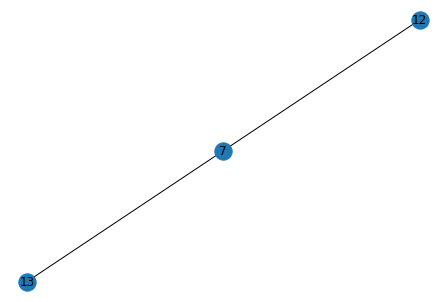

match_branches = []
edges_to_delete (resolve crossover) = [[7, 12], [7, 13], [12, 13]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([ 7, 12]), array([ 7, 13]), array([12, 13])]
edges_to_create = []
Number of connected components = 3
Comp 0 = {1, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
Comp 1 = {8, 6, 7}
Comp 2 = {0, 2, 3, 4, 5, 9, 10, 11, 12}
curr_limb_copy.deleted_edges = [array([ 7, 12]), array([ 7, 13]), array([12, 13])]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [array([ 7, 12]), array([ 7, 13]), array([12, 13])], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 3: [array([ 1, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,

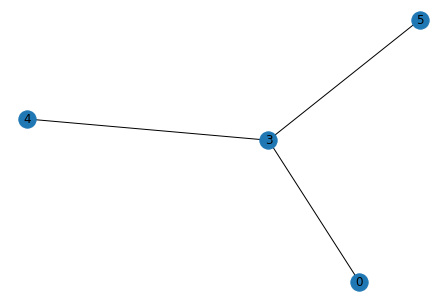

match_branches = [[0, 5], [3, 4]]
edges_to_delete (resolve crossover) = [[0, 3], [0, 4], [3, 5], [4, 5]]
edges_to_create (resolve crossover) = [[0, 5], [3, 4]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[0, 3], [0, 4], [3, 5], [4, 5]]
edges_to_create = [[0, 5], [3, 4]]
Number of connected components = 2
Comp 0 = {0, 1, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18}
Comp 1 = {2, 10, 3, 4}
curr_limb_copy.deleted_edges = [[0, 3], [0, 4], [3, 5], [4, 5]]
curr_limb_copy.created_edges = [[0, 5], [3, 4]]
After get best cut: cut_edges = [[0, 3], [0, 4], [3, 5], [4, 5]], added_edges = [[0, 5], [3, 4]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([ 0,  1,  5,  6,  7,  8,  9, 11

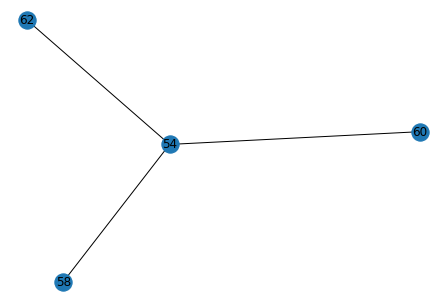

match_branches = [[54, 62]]
edges_to_delete (resolve crossover) = [[54, 58], [54, 60], [58, 60], [58, 62], [60, 62]]
edges_to_create (resolve crossover) = [[54, 62]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 176 because skeletal distance was 987.0282136138536 and threshold was 2500
skip_nodes = [176]
edges_to_delete (cut_limb_network) = [[54, 58], [54, 60], [58, 60], [58, 62], [60, 62]]
edges_to_create = [[54, 62]]
Number of connected components = 11
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92, 93, 94, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 1

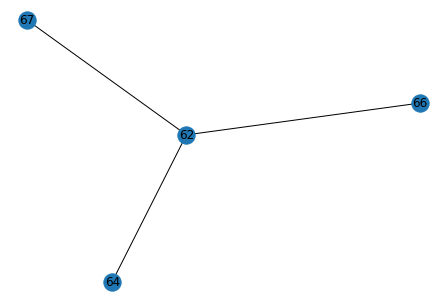

match_branches = [[62, 67]]
edges_to_delete (resolve crossover) = [[62, 64], [62, 66], [64, 66], [64, 67], [66, 67]]
edges_to_create (resolve crossover) = [[62, 67]]
curr_limb.deleted_edges 5 =[[54, 58], [54, 60], [58, 60], [58, 62], [60, 62]]
Skipping endnode 176 because skeletal distance was 987.0282136138536 and threshold was 2500
skip_nodes = [176]
edges_to_delete (cut_limb_network) = [[62, 64], [62, 66], [64, 66], [64, 67], [66, 67]]
edges_to_create = [[62, 67]]
Number of connected components = 13
Comp 0 = {1, 8, 10, 11, 25, 64, 70, 71, 72, 75, 76, 77, 78, 79, 81, 83, 87, 89, 90, 91, 93, 94, 97, 107, 109, 110, 114, 116, 117, 118, 121, 124, 125, 126, 128, 129, 130, 131, 132, 134, 135, 137, 138, 139, 140, 141, 142, 146, 147, 148, 149, 150, 151, 152, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 186, 187, 189, 190, 191, 192, 193, 200, 201, 203, 204, 205, 206, 208, 209, 211, 212, 213}
Co

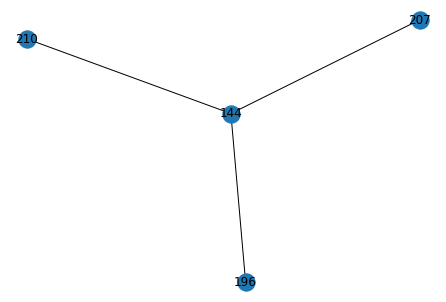

match_branches = [[144, 210], [196, 207]]
edges_to_delete (resolve crossover) = [[144, 196], [144, 207], [196, 210], [207, 210]]
edges_to_create (resolve crossover) = [[144, 210], [196, 207]]
curr_limb.deleted_edges 5 =[[54, 58], [54, 60], [58, 60], [58, 62], [60, 62], [62, 64], [62, 66], [64, 66], [64, 67], [66, 67]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[144, 196], [144, 207], [196, 210], [207, 210]]
edges_to_create = [[144, 210], [196, 207]]
Number of connected components = 14
Comp 0 = {1, 8, 10, 11, 25, 64, 70, 71, 72, 75, 76, 77, 78, 79, 81, 83, 87, 89, 90, 91, 93, 94, 97, 107, 109, 110, 114, 116, 117, 118, 121, 124, 125, 126, 128, 129, 130, 131, 132, 134, 135, 137, 138, 139, 140, 141, 142, 146, 147, 148, 149, 150, 151, 152, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 186, 187, 189, 190, 191, 192, 193, 200, 201, 203, 204, 205, 206, 208, 209, 211, 212, 213}
Comp 1 = 

No skeletons to stack so returning empty list
No upstream skeletons so doing backup
  Edge: [176 172]: curr_angle = 31.3
  Edge: [172 180]: curr_angle = 90.48

Total time for doubling_back = 0.05908083915710449

Attempting the width jump check (attempting from both sides)
No skeletons to stack so returning empty list
No upstream skeletons so doing backup
  Edge: [176 172]: jump = -385.38
  Edge: [172 180]: jump = -370.8
Total time for width = 0.028713226318359375
Path starting at 176 had err_edges: []
  Edge: [180 172]: jump = 250.29
Adding error edge [180 172] because width jump was 250.2901516199837
  Edge: [172 176]: jump = 385.38
Adding error edge [172 176] because width jump was 385.38188258235334
Total time for width = 0.026310205459594727
Path starting at 180 had err_edges: [[180, 172], [172, 176]]
first_error_sizes = [-inf, 250.2901516199837], winning_path = 1
***inside resolve crossover!!!!****
coordinate_branches = [170, 172, 180]
170 = red
172 = aqua
180 = purple
Angle betwe

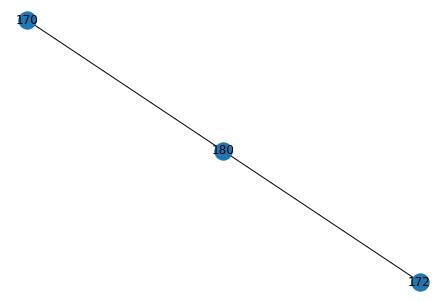

match_branches = []
edges_to_delete (resolve crossover) = [[170, 172], [170, 180], [172, 180]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([170, 172]), array([170, 180]), array([172, 180])]
edges_to_create = []
Number of connected components = 16
Comp 0 = {180}
Comp 1 = {1, 8, 10, 11, 25, 64, 70, 71, 72, 75, 76, 77, 78, 79, 81, 83, 87, 89, 90, 91, 93, 94, 97, 107, 109, 110, 114, 116, 117, 118, 121, 124, 125, 126, 128, 129, 130, 131, 132, 134, 135, 137, 138, 139, 140, 141, 142, 146, 147, 148, 149, 150, 151, 152, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 173, 175, 179, 181, 182, 183, 184, 187, 189, 191, 200, 201, 203, 204, 205, 206, 208, 209, 211, 212, 213}
Comp 2 = {192, 193, 168, 172, 176, 177, 178, 186, 190}
Comp 3 = {0, 2, 3, 4, 5, 6, 7, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 

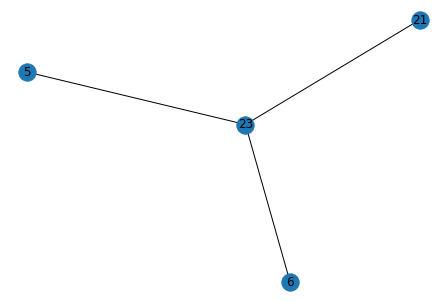

match_branches = [[6, 21], [5, 23]]
edges_to_delete (resolve crossover) = [[5, 6], [5, 21], [6, 23], [21, 23]]
edges_to_create (resolve crossover) = [[6, 21], [5, 23]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[5, 6], [5, 21], [6, 23], [21, 23]]
edges_to_create = [[6, 21], [5, 23]]
Number of connected components = 3
Comp 0 = {3, 4, 5, 13, 23, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57}
Comp 1 = {0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30}
Comp 2 = {22}
curr_limb_copy.deleted_edges = [[5, 6], [5, 21], [6, 23], [21, 23]]
curr_limb_copy.created_edges = [[6, 21], [5, 23]]
After get best cut: cut_edges = [[5, 6], [5, 21], [6, 23], [21, 23]], added_edges = [[6, 21], [5, 23]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of 

  Edge: [31 33]: curr_angle = 121.4

Total time for doubling_back = 0.05330348014831543
There were 1 edges that passed doubling back threshold of 100
Winning edge [31 33] had a doubling back of 121.40234534335082
***inside resolve crossover!!!!****
coordinate_branches = [31, 32, 33]
31 = red
32 = aqua
33 = purple
Angle between 31 and 32 = 57.96 
Angle between 31 and 33 = 106.09 
Angle between 32 and 33 = 17.85 
Final Matches = [[32, 33]]
matched_branches_revised = [[32, 33]]
Original graph


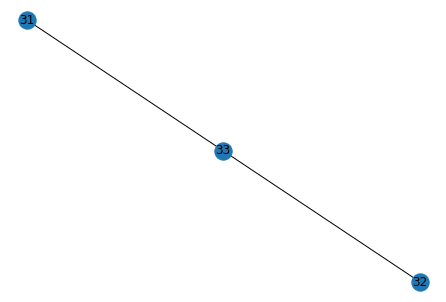

match_branches = [[32, 33]]
edges_to_delete (resolve crossover) = [[31, 32], [31, 33]]
edges_to_create (resolve crossover) = [[32, 33]]
edges_to_delete (cut_limb_network) = [array([31, 32]), array([31, 33])]
edges_to_create = [[32, 33]]
Number of connected components = 4
Comp 0 = {3, 4, 5, 13, 23, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57}
Comp 1 = {31}
Comp 2 = {0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30}
Comp 3 = {22}
curr_limb_copy.deleted_edges = [[5, 6], [5, 21], [6, 23], [21, 23], array([31, 32]), array([31, 33])]
curr_limb_copy.created_edges = [[6, 21], [5, 23], [32, 33]]
After get best cut: cut_edges = [array([31, 32]), array([31, 33])], added_edges = [[32, 33]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 4
Total number of graphs at the end of the split AFTER DIRECTI

  Edge: [33 35]: curr_angle = 18.5
  Edge: [35 37]: curr_angle = 131.92
  Edge: [37 34]: curr_angle = 21.27

Total time for doubling_back = 0.06971001625061035
There were 1 edges that passed doubling back threshold of 100
Winning edge [35 37] had a doubling back of 131.91951598360117
***inside resolve crossover!!!!****
coordinate_branches = [34, 35, 37]
34 = red
35 = aqua
37 = purple
Angle between 34 and 35 = 53.31 
Angle between 34 and 37 = 30.13 
Angle between 35 and 37 = 99.43 
Final Matches = [[34, 37]]
matched_branches_revised = [[34, 37]]
Original graph


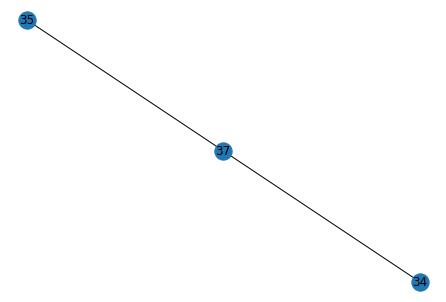

match_branches = [[34, 37]]
edges_to_delete (resolve crossover) = [[34, 35], [35, 37]]
edges_to_create (resolve crossover) = [[34, 37]]
edges_to_delete (cut_limb_network) = [array([34, 35]), array([35, 37])]
edges_to_create = [[34, 37]]
Number of connected components = 5
Comp 0 = {13, 32, 33, 35, 36, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55}
Comp 1 = {31}
Comp 2 = {34, 3, 4, 5, 37, 38, 23, 56, 57}
Comp 3 = {0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30}
Comp 4 = {22}
curr_limb_copy.deleted_edges = [[5, 6], [5, 21], [6, 23], [21, 23], array([31, 32]), array([31, 33]), array([34, 35]), array([35, 37])]
curr_limb_copy.created_edges = [[6, 21], [5, 23], [32, 33], [34, 37]]
After get best cut: cut_edges = [array([34, 35]), array([35, 37])], added_edges = [[34, 37]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 5
Total 

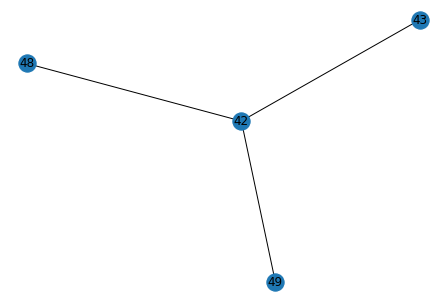

match_branches = [[43, 49]]
edges_to_delete (resolve crossover) = [[42, 43], [42, 48], [42, 49], [43, 48], [48, 49]]
edges_to_create (resolve crossover) = [[43, 49]]
curr_limb.deleted_edges 5 =[[5, 6], [5, 21], [6, 23], [21, 23], array([31, 32]), array([31, 33]), array([34, 35]), array([35, 37])]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[42, 43], [42, 48], [42, 49], [43, 48], [48, 49]]
edges_to_create = [[43, 49]]
Number of connected components = 8
Comp 0 = {40, 43, 44, 45, 46, 49, 50, 51, 52, 53, 54, 55}
Comp 1 = {32, 33, 35, 36, 39, 41, 42, 13}
Comp 2 = {48}
Comp 3 = {31}
Comp 4 = {34, 3, 4, 5, 37, 38, 23, 56, 57}
Comp 5 = {0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30}
Comp 6 = {22}
Comp 7 = {47}
curr_limb_copy.deleted_edges = [[5, 6], [5, 21], [6, 23], [21, 23], array([31, 32]), array([31, 33]), array([34, 35]), array([35, 37]), [42, 43], [42, 48], [42, 49], [43, 48], [48, 49]]
curr_limb_copy.created_edges = [[6, 21], [5, 2

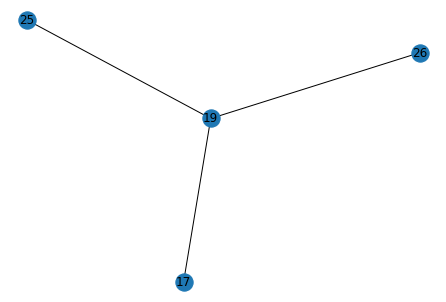

match_branches = [[17, 26], [19, 25]]
edges_to_delete (resolve crossover) = [[17, 19], [17, 25], [19, 26], [25, 26]]
edges_to_create (resolve crossover) = [[17, 26], [19, 25]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[17, 19], [17, 25], [19, 26], [25, 26]]
edges_to_create = [[17, 26], [19, 25]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 4, 15, 18, 19, 20, 21, 22, 23, 24, 25}
Comp 1 = {5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 26, 27, 28}
curr_limb_copy.deleted_edges = [[17, 19], [17, 25], [19, 26], [25, 26]]
curr_limb_copy.created_edges = [[17, 26], [19, 25]]
After get best cut: cut_edges = [[17, 19], [17, 25], [19, 26], [25, 26]], added_edges = [[17, 26], [19, 25]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connectio

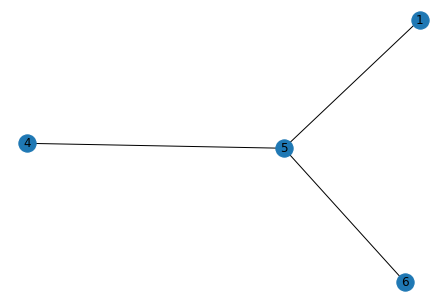

match_branches = [[1, 4]]
edges_to_delete (resolve crossover) = [[1, 5], [1, 6], [4, 5], [4, 6], [5, 6]]
edges_to_create (resolve crossover) = [[1, 4]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[1, 5], [1, 6], [4, 5], [4, 6], [5, 6]]
edges_to_create = [[1, 4]]
Number of connected components = 4
Comp 0 = {8, 1, 4, 7}
Comp 1 = {0, 2, 3, 5, 9, 11, 12, 13, 14}
Comp 2 = {6}
Comp 3 = {10}
curr_limb_copy.deleted_edges = [[1, 5], [1, 6], [4, 5], [4, 6], [5, 6]]
curr_limb_copy.created_edges = [[1, 4]]
After get best cut: cut_edges = [[1, 5], [1, 6], [4, 5], [4, 6], [5, 6]], added_edges = [[1, 4]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 4
Total number of graphs at the end of the split AFTER DIRECTIONAL = 4
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 4: [array([8, 1, 4, 7]), array([ 0,  2,  3,  

In [23]:
start_time = time.time()
if not test_mode:
    time.sleep(random.randint(0, 800))
print('Populate Started')
if not test_mode:
    NeuronSplitSuggestions.populate(reserve_jobs=True, suppress_errors=True)
else:
    NeuronSplitSuggestions.populate(reserve_jobs=True, suppress_errors=True)
print('Populate Done')

print(f"Total time for NeuronSplitSuggestions populate = {time.time() - start_time}")